In [81]:
from collections import defaultdict
from pathlib import Path
import json
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import numpy as np


TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def get_best_agent_metrics():
    best_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    specific_exp_dir = Path("../logs/specific")
    for exp_dir in specific_exp_dir.iterdir():

        returns = []
        for seed_dir in exp_dir.iterdir():
            if (seed_dir / "eval.jsonl").exists():
                metrics = json.loads((seed_dir / "eval.jsonl").read_text().split("\n")[0])
                returns.append(metrics["return"])
        if len(returns) == 0:
            continue
        task = None
        for k in best_agent_metrics:
            if k in exp_dir.name:
                task = k
                break
        
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        
        ctx_k_v_str = exp_dir.name.split("specific_")[1].split("_enc")[0]
        
        ctx_val = [default_0, default_1]
        for k_v in ctx_k_v_str.split("_"):
            k, v = k_v.split("-")
            v = float(v)
            k = int(k)
            ctx_val[int(k)] = v
        best_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(returns)
    return best_agent_metrics

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_best_agent_metrics(best_agent_metrics, save_dir):

    for task in best_agent_metrics:
        x = []
        y = []
        c = []
        for ctx_0_value, ctx_1_value in best_agent_metrics[task]:
            x.append(ctx_0_value)
            y.append(ctx_1_value)
            c.append(best_agent_metrics[task][(ctx_0_value, ctx_1_value)])
        ctx_0 = _TASK2CONTEXTS[task][0]["context"].replace("_", " ").title()
        ctx_1 = _TASK2CONTEXTS[task][1]["context"].replace("_", " ").title()

        df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c})
        df = df.pivot(index=ctx_0, columns=ctx_1, values="return")
        
        # sort the rows descending
        df = df.sort_index(ascending=False)

        
        # darker colors for higher values, red color map
        ax = sns.heatmap(df, cmap=sns.cm.rocket_r, annot=True, fmt=".0f")

        # Title should be task - modality - context_name
        # bold the context name
        if task == "classic_cartpole":
            task = "Cartpole"
        elif task == "dmc_walker":
            task = "dmc Walker"
        title = f"{task} - Expert Agent - Return"
        save_path = save_dir / f"{task}_expert.pdf"
        plt.title(title)
        plt.savefig(save_path)
        plt.pause(0.1)

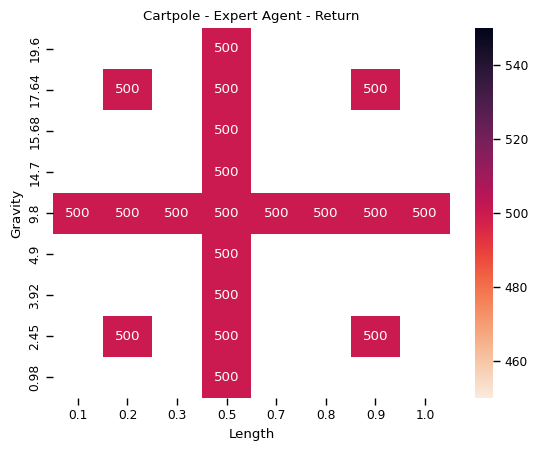

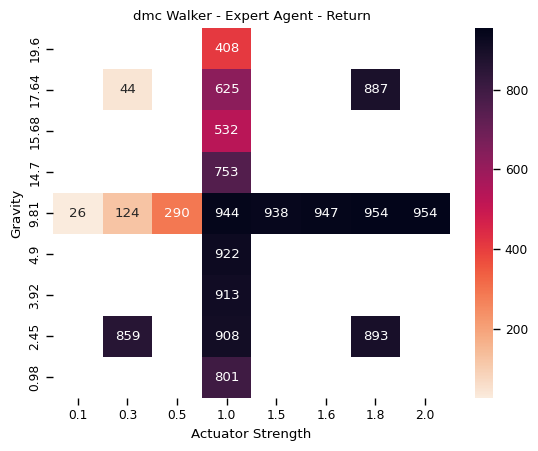

In [83]:
best_agent_metrics = get_best_agent_metrics()
save_dir = Path("./plots/")
plot_best_agent_metrics(best_agent_metrics, save_dir)

In [84]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}
sns.set_context("paper")
def plot_bar_chart(task, context_idx, modality, save_dir, log_dir, best_agent_metrics, plot_y="return", suffix="50k"):
    single_setting = f"single_{context_idx}"
    
    experiments = [
        log_dir / f"carl_{task}_default_enc_{modality}_dec_{modality}_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_ctx_dec_{modality}_ctx_{suffix}",
        log_dir / f"carl_{task}_{single_setting}_enc_{modality}_dec_{modality}_pgm_ctx_{suffix}",
    ] 
    exp_types = [
        "Default", "No context", "Simple context", "cRSSM"
    ]
    modality = "Featurized Observation" if modality == "obs" else "Pixel Observation"

    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    data = {
        "Context": [],
        "Experiment": [],
        "Return": [],
    }
    seeds = 0
    for i, exp_path in enumerate(experiments):
        exp_type = exp_types[i]
        for seed_path in exp_path.iterdir():
            eval_file = seed_path / "eval.jsonl"
            if not eval_file.exists():
                continue
            seeds += 1
            with eval_file.open() as f:
                lines = f.readlines()
            lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
            for line in lines:
                if context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0:
                    ctx_value = line['ctx']["context"][context_name]
                    ret = float(line['return'])
                    data["Context"].append(ctx_value)
                    data["Experiment"].append(exp_type)
                    data["Return"].append(ret)
    df = pd.DataFrame.from_dict(data)
    env = _TASK2ENV[task]

    default_context_val = env.get_default_context()[context_name]

    interpolate_range = _TASK2CONTEXTS[task][context_idx]["train_range"]
    
    
    other_ctx_id = 1 - context_idx
    other_ctx_name = _TASK2CONTEXTS[task][other_ctx_id]["context"]
    other_default = env.get_default_context()[other_ctx_name]
    best_x = []
    best_y = []
    for ctx_val in best_agent_metrics[task]:
        if ctx_val[other_ctx_id] == other_default:
            best_x.append(ctx_val[context_idx])
            best_y.append(best_agent_metrics[task][ctx_val])
    # for each context_val in df, find nearest best_x, and use the best_y as the regret for comparison
    best_x = np.array(best_x)
    best_y = np.array(best_y)
    # create a column for regret in df
    df["Regret"] = 0.
    df["Expert"] = 0.
    # iterate over df and find the nearest best_x and use the best_y as the regret for comparison
    for i, row in df.iterrows():
        ctx_val = row["Context"]
        idx = np.argmin(np.abs(best_x - ctx_val))
        df.at[i, "Best Score"] = best_y[idx]
        df.at[i, "Regret"] = best_y[idx] - row["Return"]
            
    plt.figure(figsize=(25,10))
    
    #ax = sns.violinplot(data=df, x="context", y="return", hue="experiment", cut=0, native_scale=True, density_norm="width", width=0.75)
    sns.barplot(data=df, x="Context", y=plot_y, hue="Experiment", native_scale=True, estimator='mean')
    context_name = context_name.replace("_", " ").title()
    plt.xlabel(context_name)
    
    if plot_y == "Return":
        bestx_s, besty_s = zip(*sorted(zip(best_x, best_y)))
        plt.step(bestx_s, besty_s, color='C3', linestyle='--', where='mid', label="Best expert agent")

    plt.xticks(df["Context"].unique())
    plt.axvline(default_context_val, color='C2', linestyle='--', label="default context")
    plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='C2', alpha=0.1, label="train range")
    plt.legend()
    # add legend for the background
    # set the y axis to go from 0 to max return
    plt.ylim(0, TASK2MaxReturn[task] + 10)

    # Title should be task - modality - context_name
    # bold the context name
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    title = f"{task} - {modality}"
    save_path = save_dir / f"{task}_{context_name}_{modality}_{plot_y}.pdf"
    plt.title(title)
    plt.savefig(save_path)
    plt.pause(0.1)
    if seeds != 40:
        print(experiments)
        print(f"not enough seeds - {title} - {seeds}")        

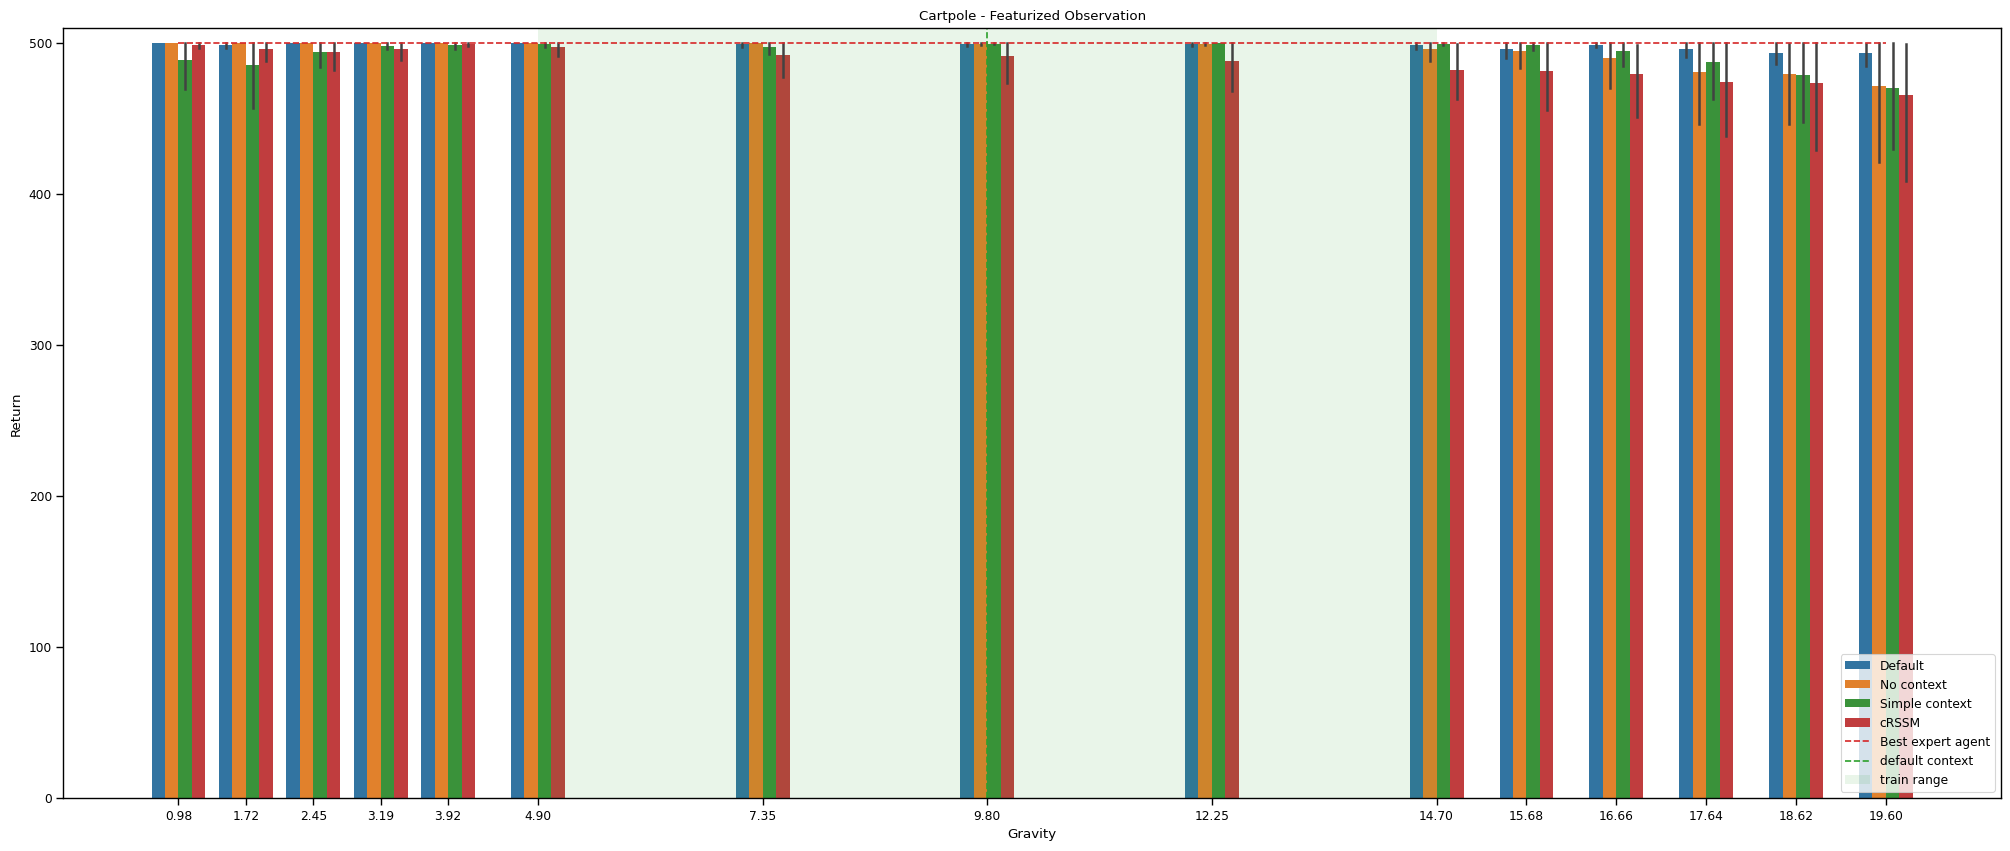

Return


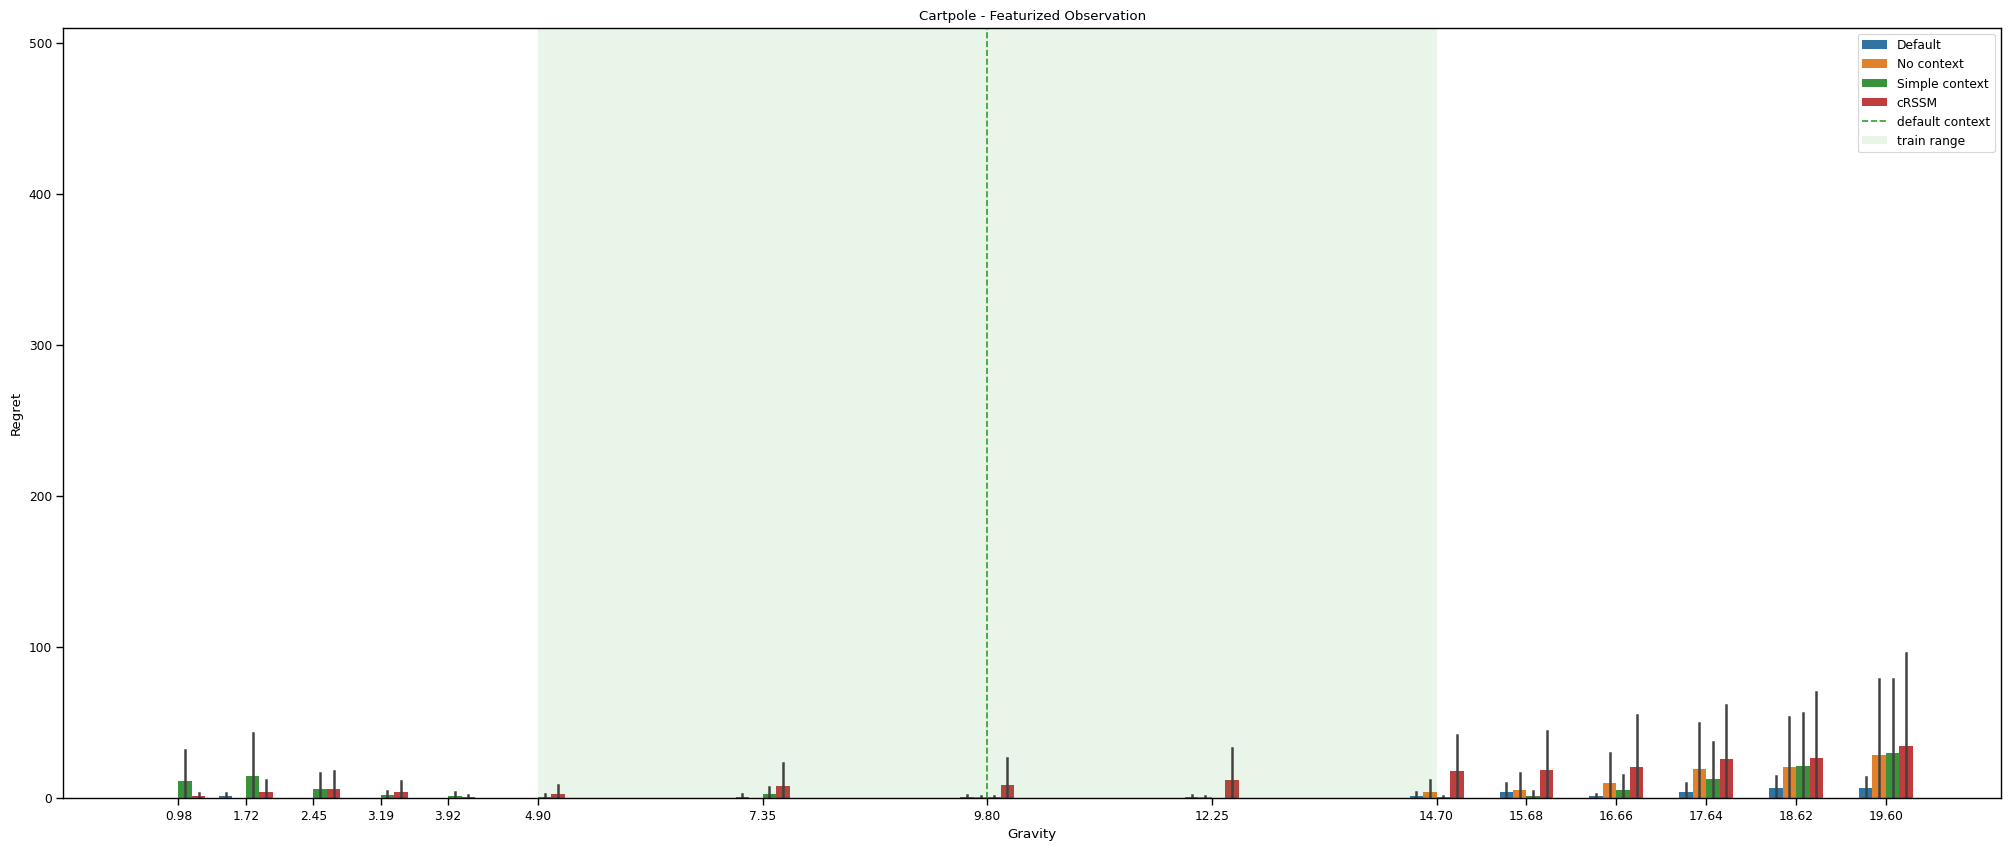

Regret


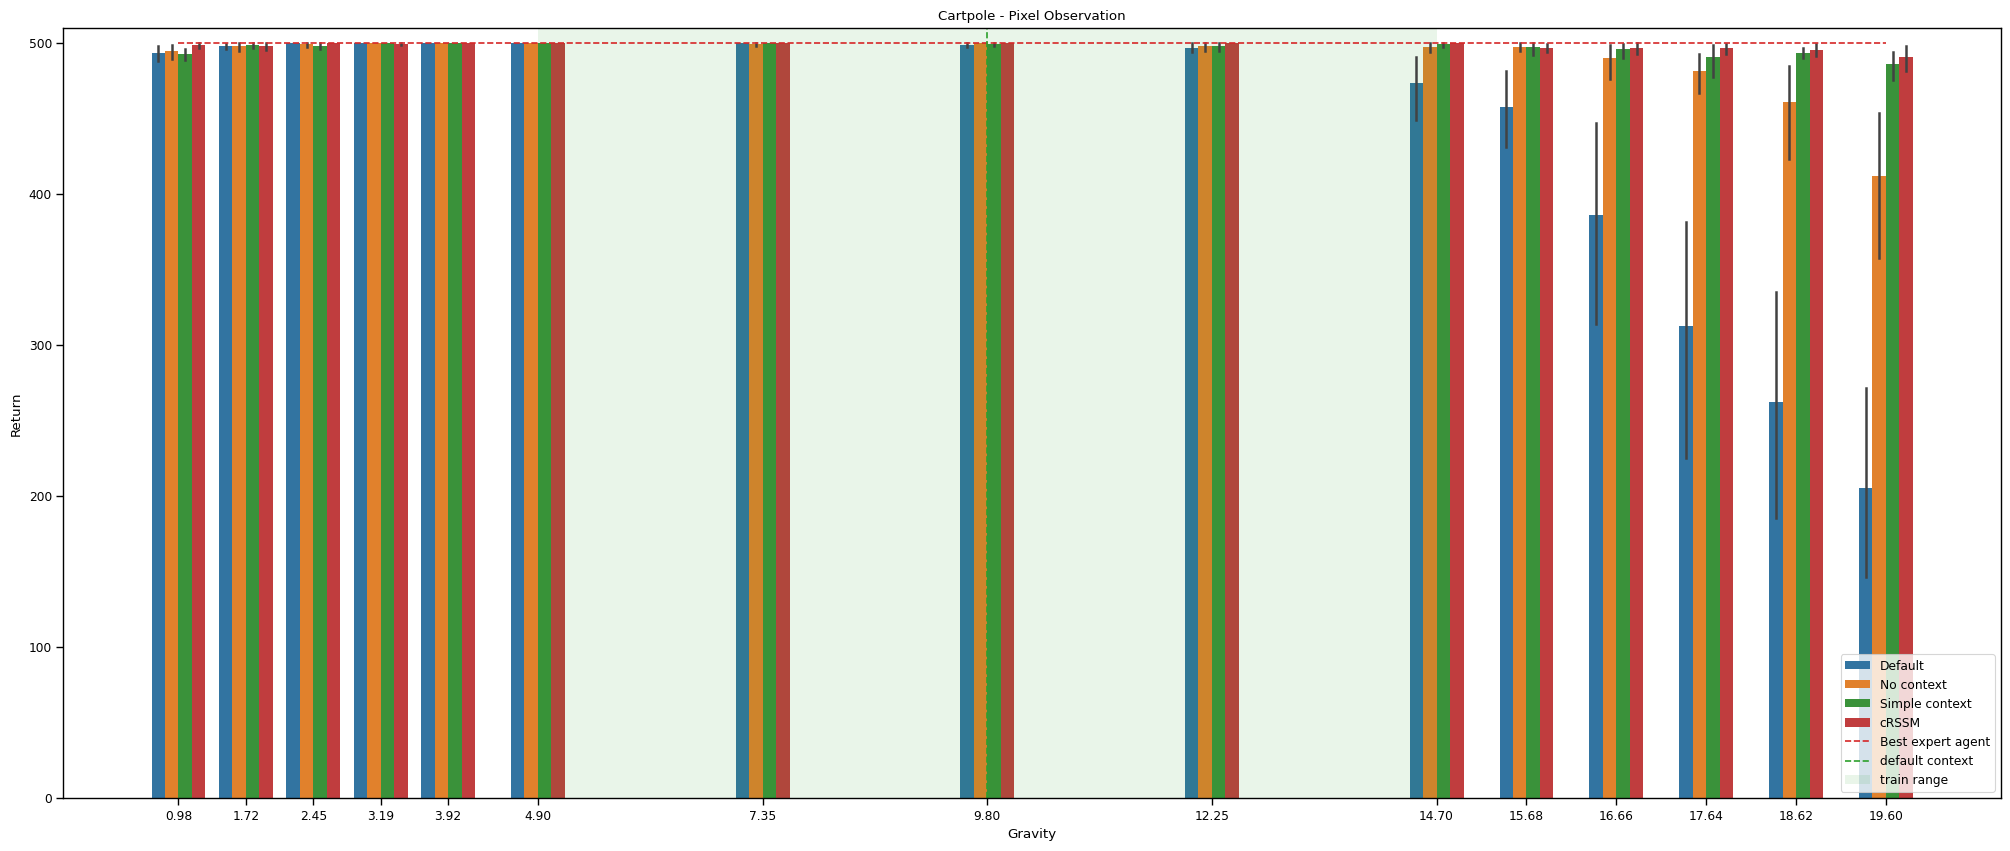

Return


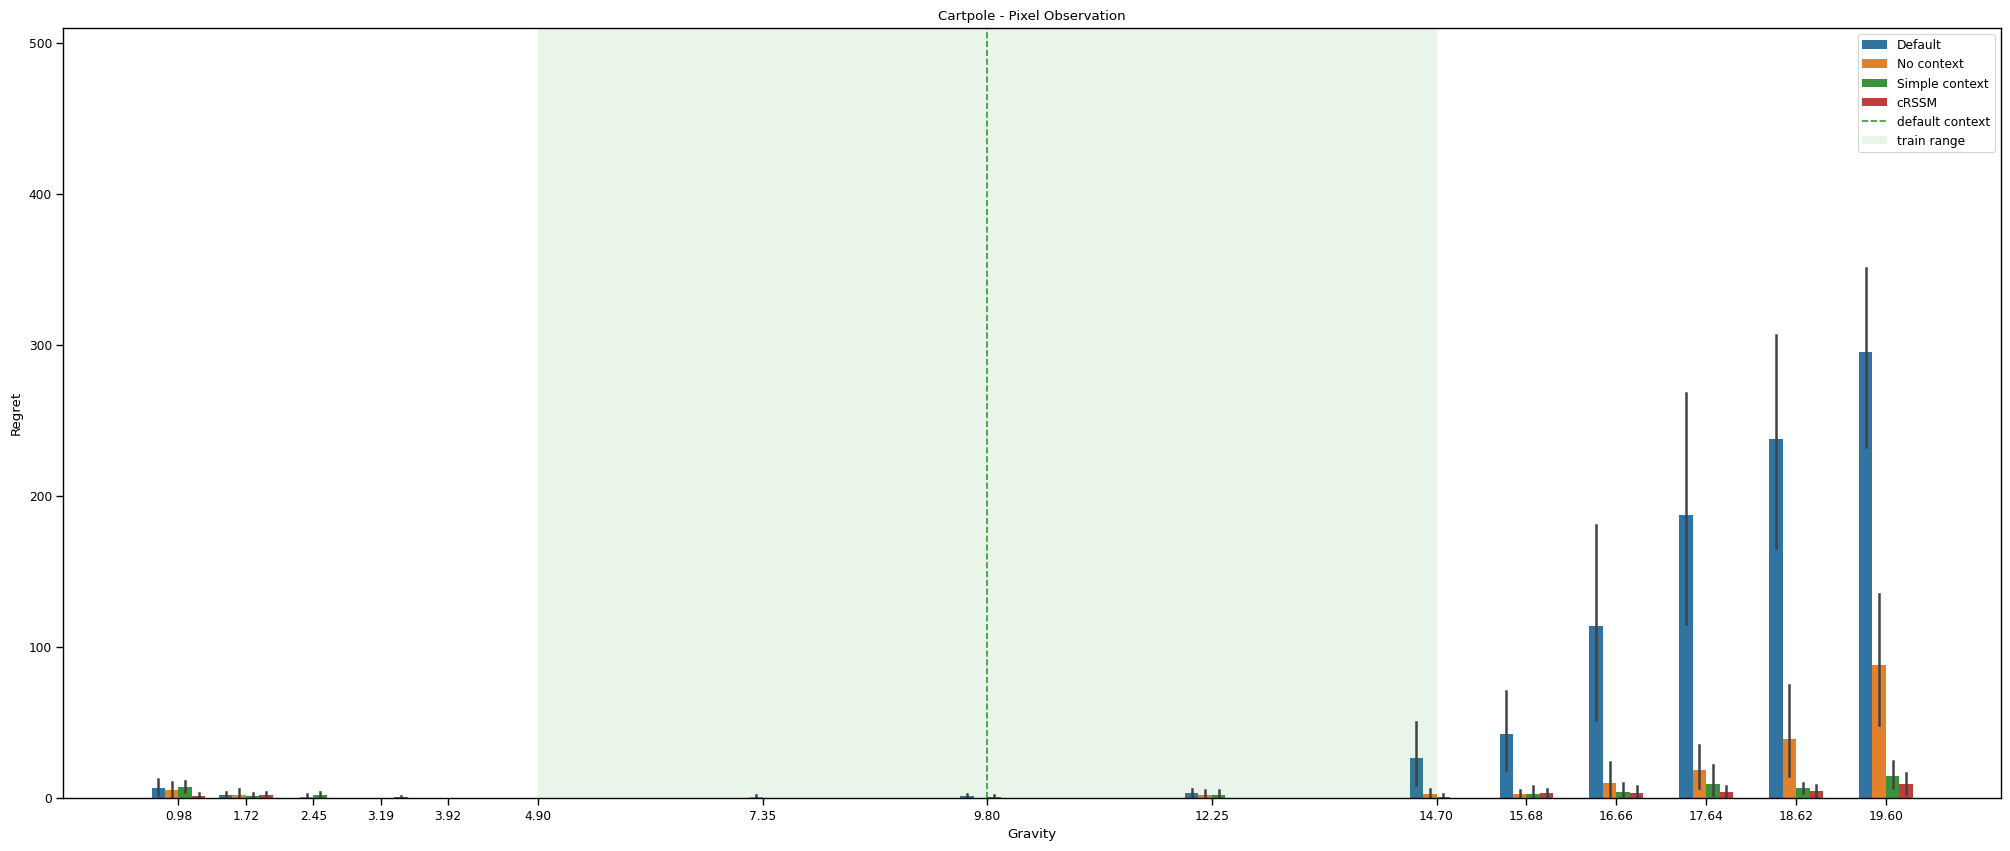

Regret


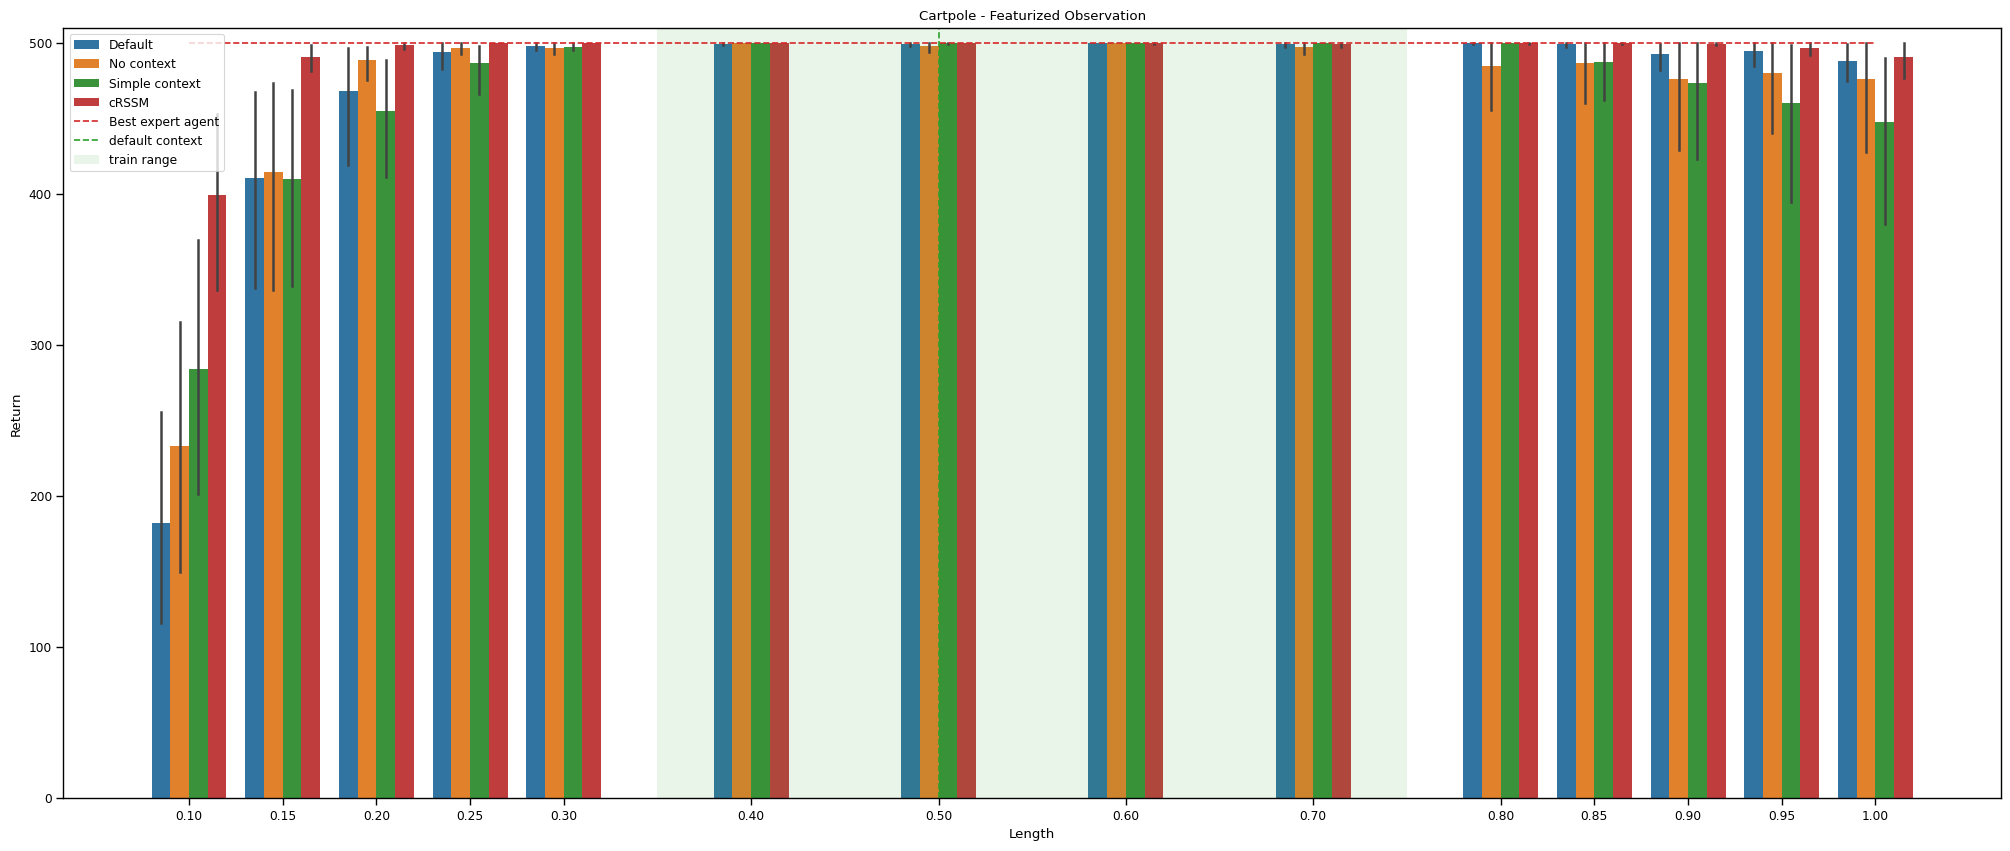

Return


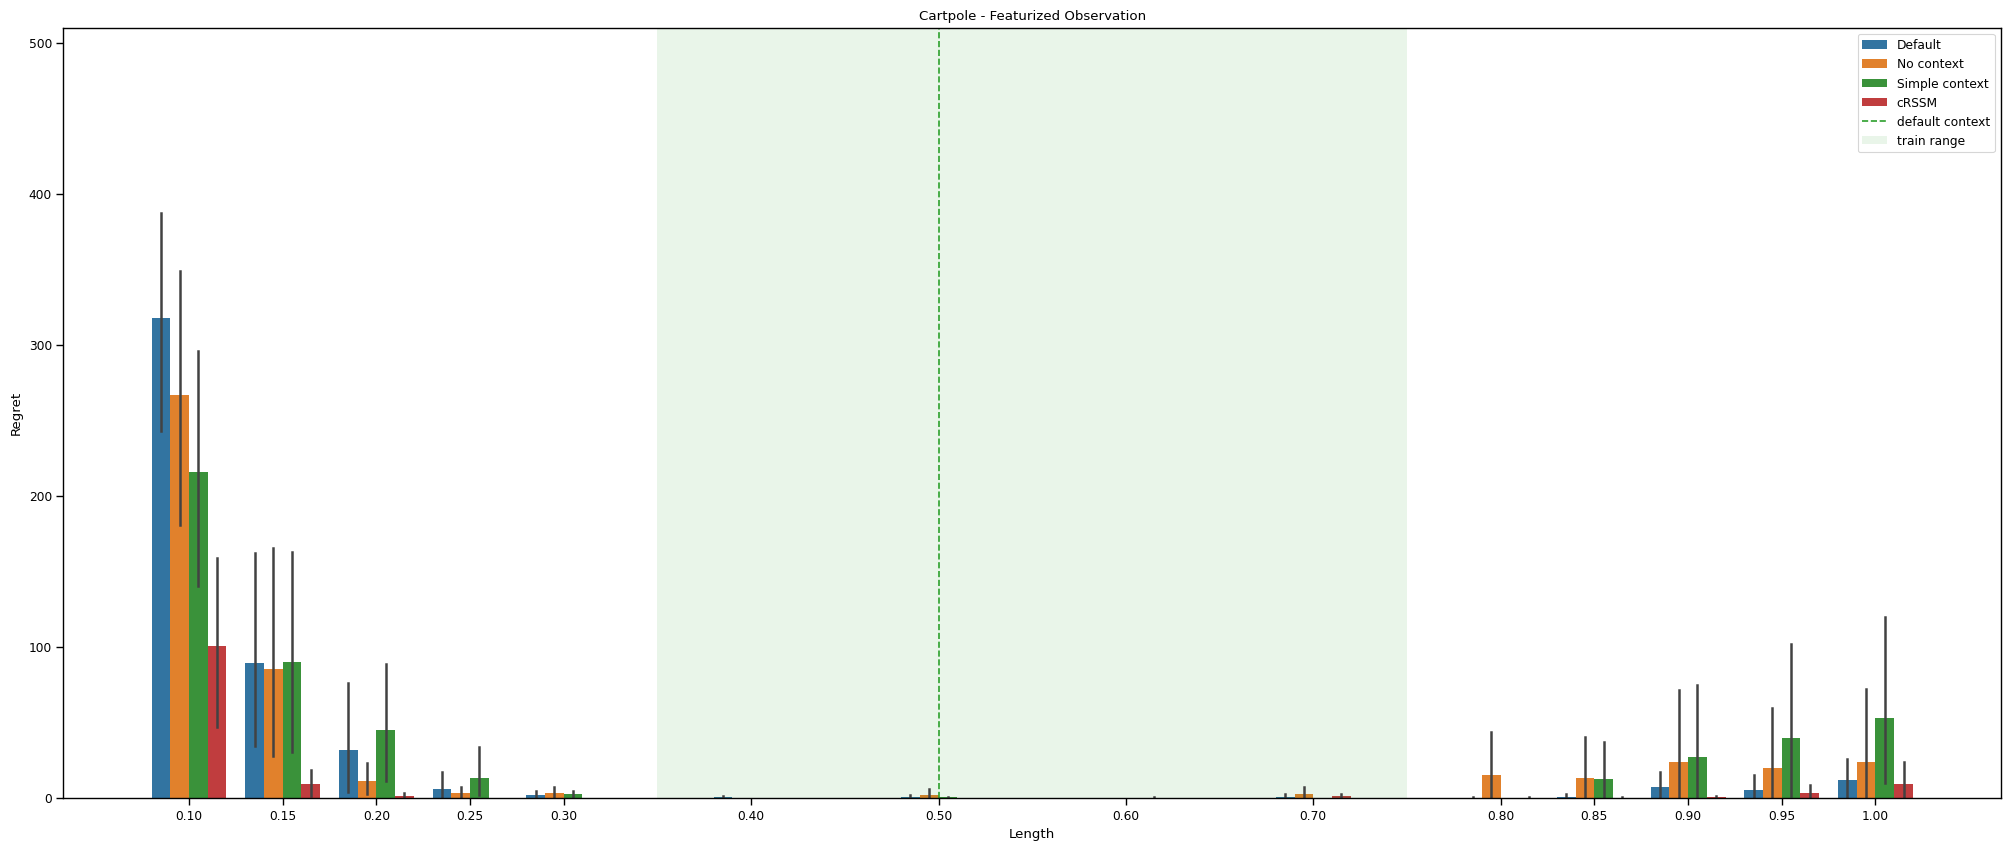

Regret


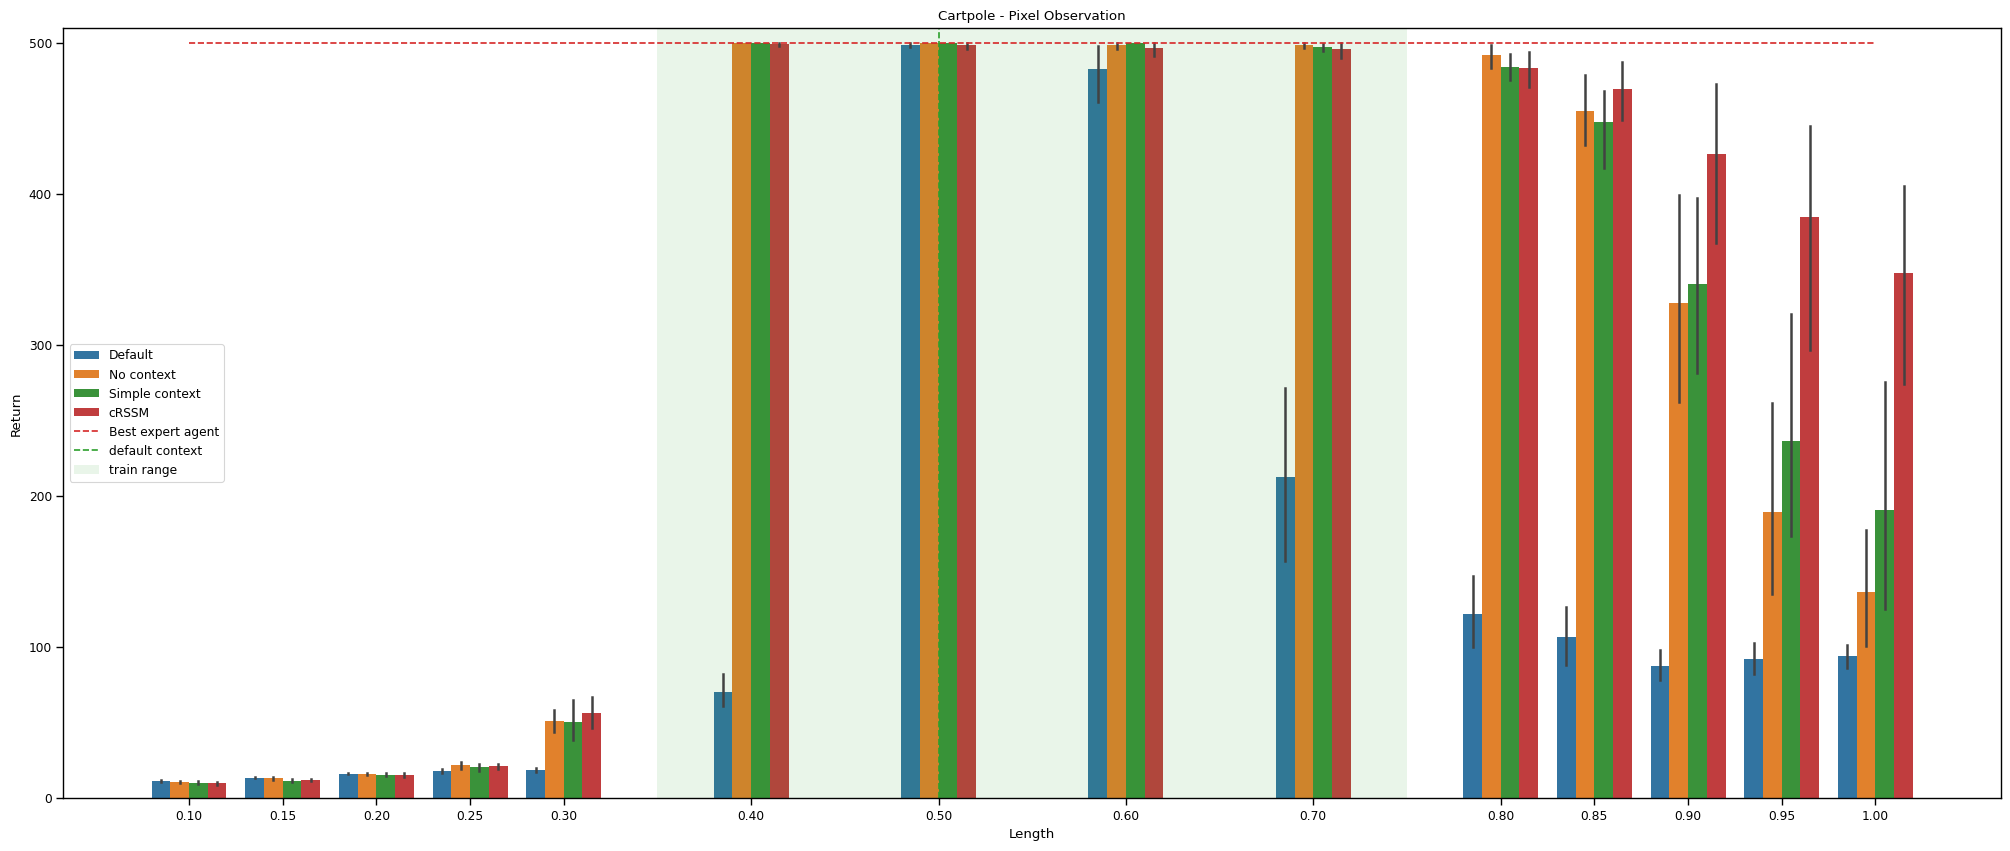

Return


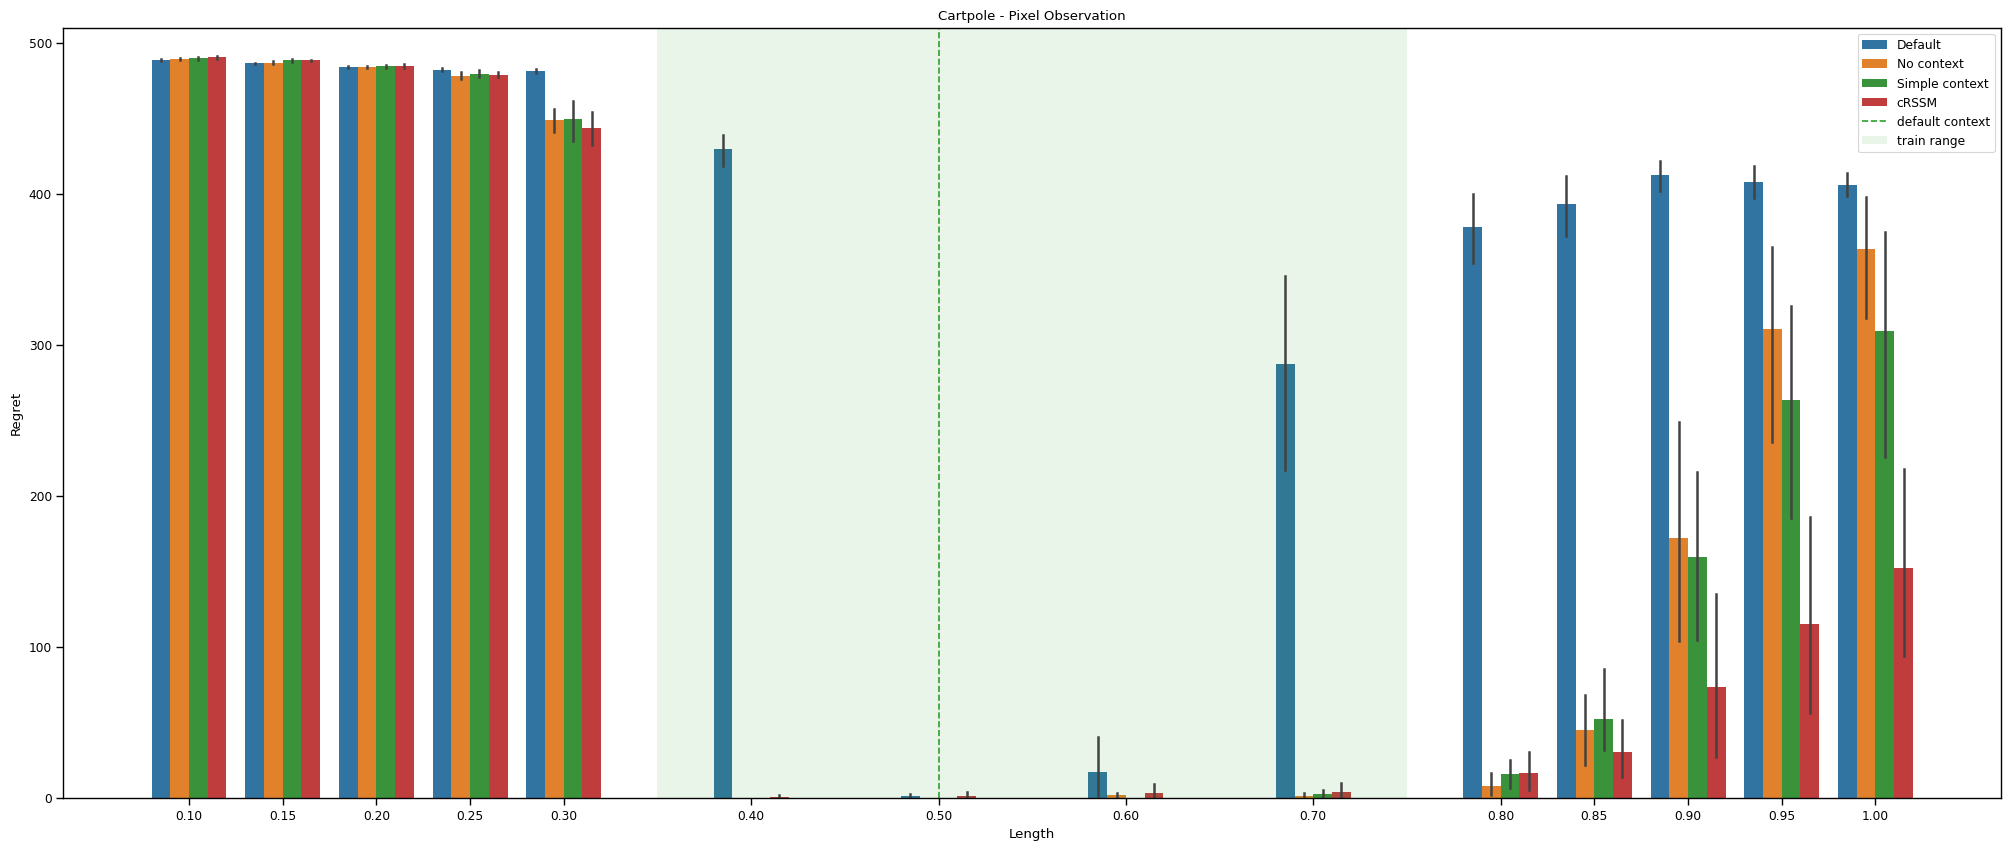

Regret


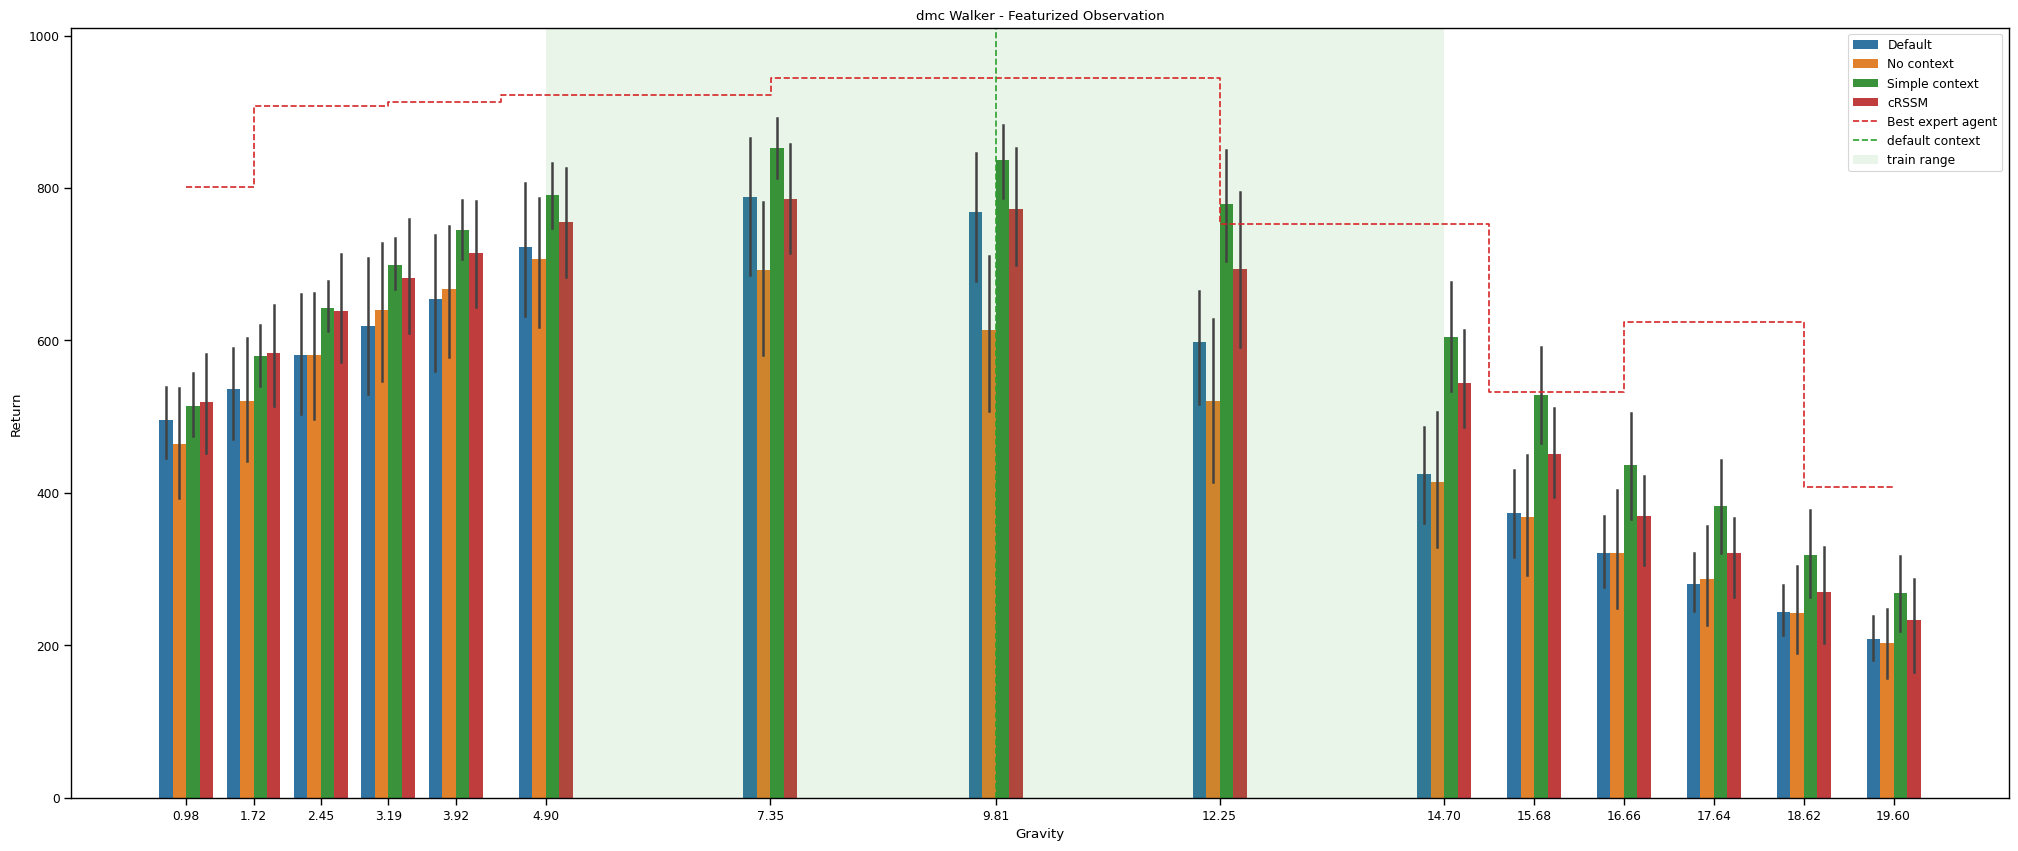

[PosixPath('../logs/carl_dmc_walker_default_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_obs_ctx_dec_obs_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_obs_dec_obs_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Featurized Observation - 33
Return


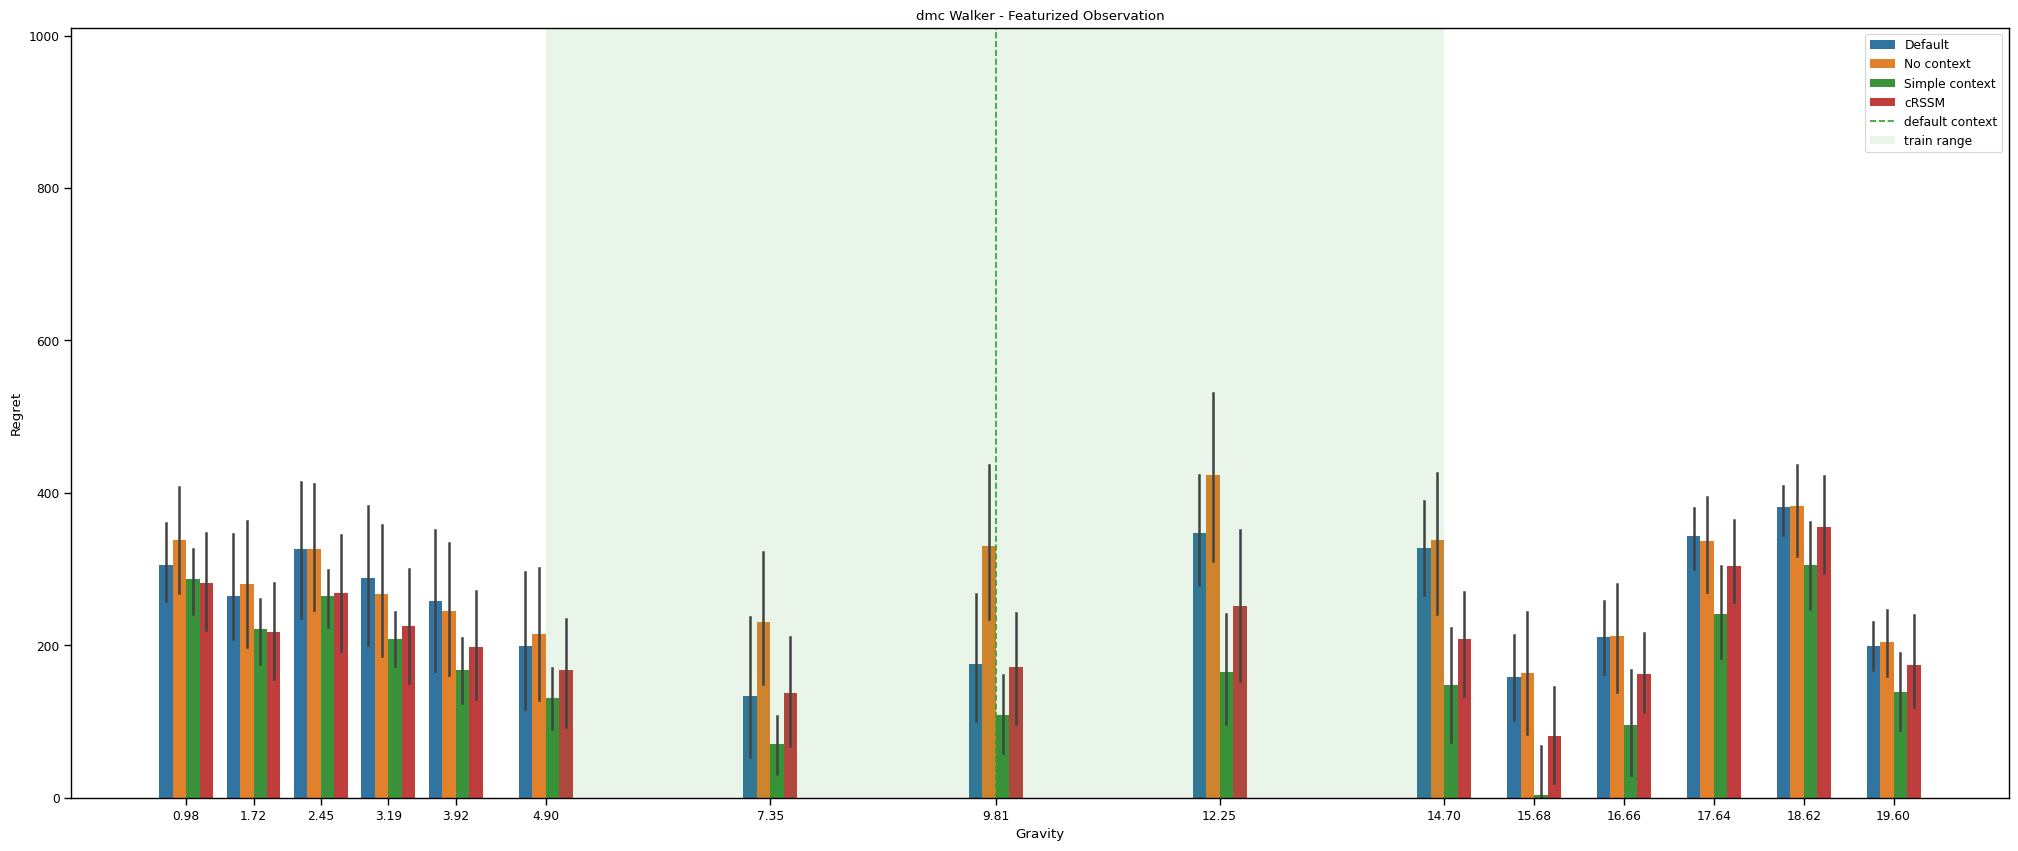

[PosixPath('../logs/carl_dmc_walker_default_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_obs_ctx_dec_obs_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_obs_dec_obs_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Featurized Observation - 33
Regret


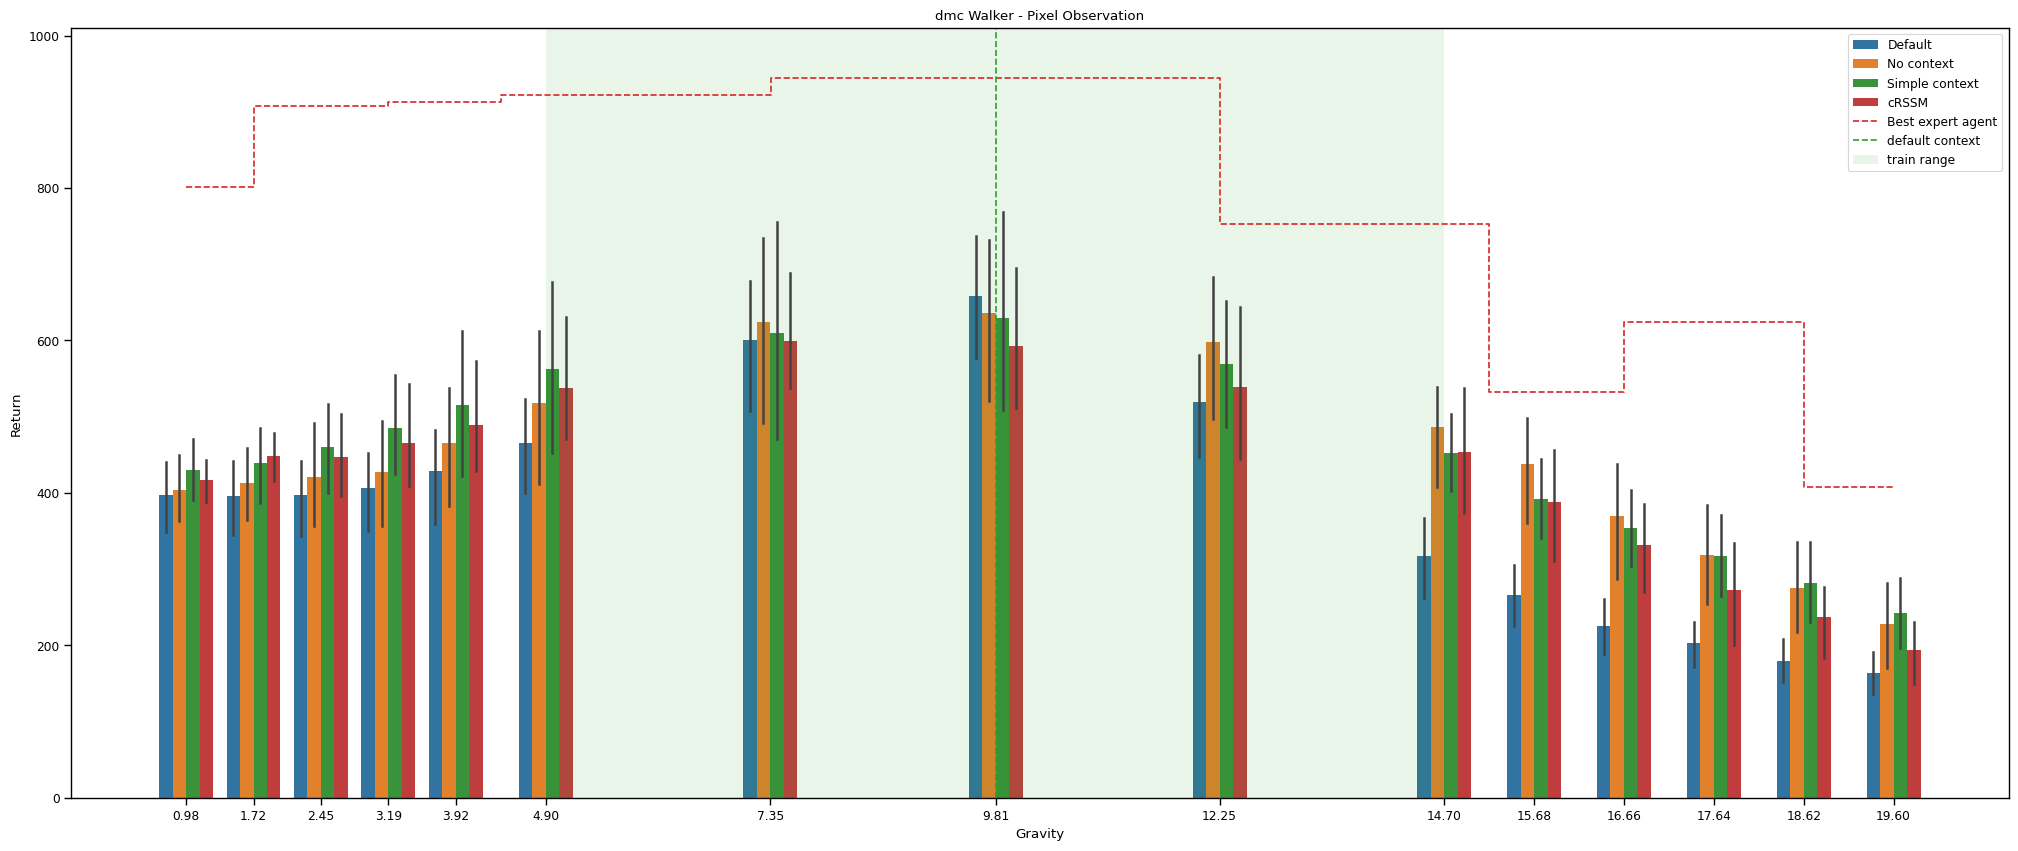

[PosixPath('../logs/carl_dmc_walker_default_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_img_ctx_dec_img_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_img_dec_img_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Pixel Observation - 31
Return


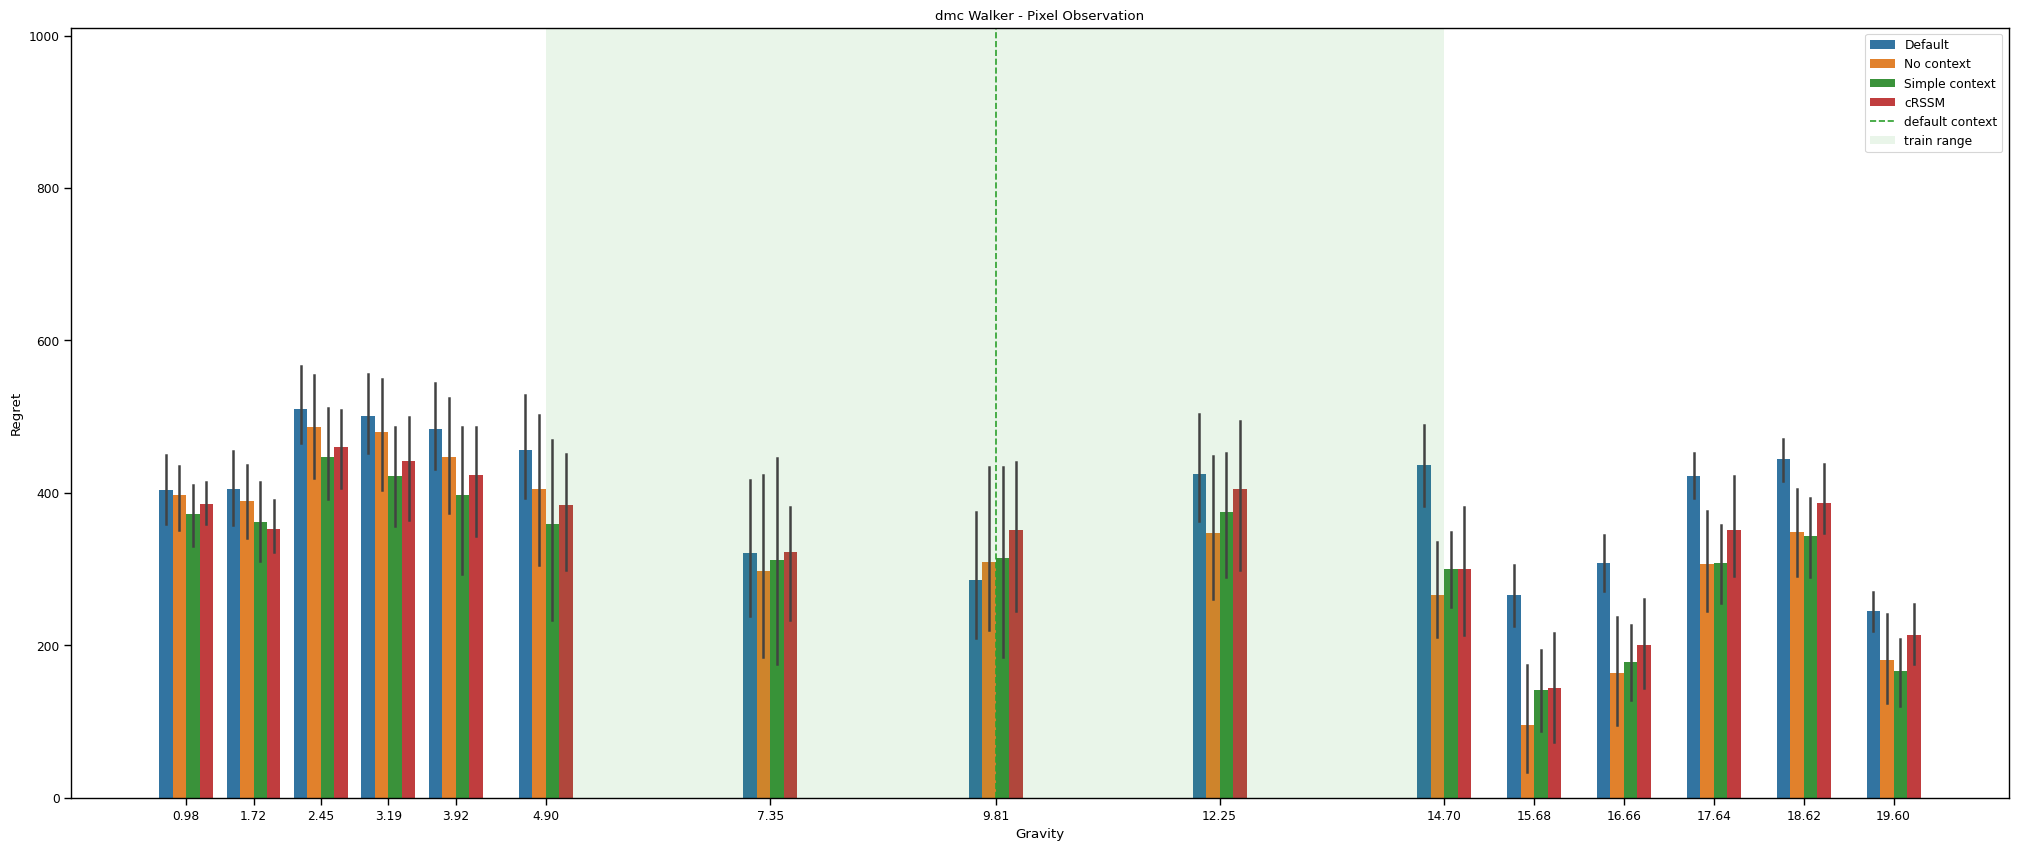

[PosixPath('../logs/carl_dmc_walker_default_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_img_ctx_dec_img_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_0_enc_img_dec_img_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Pixel Observation - 31
Regret


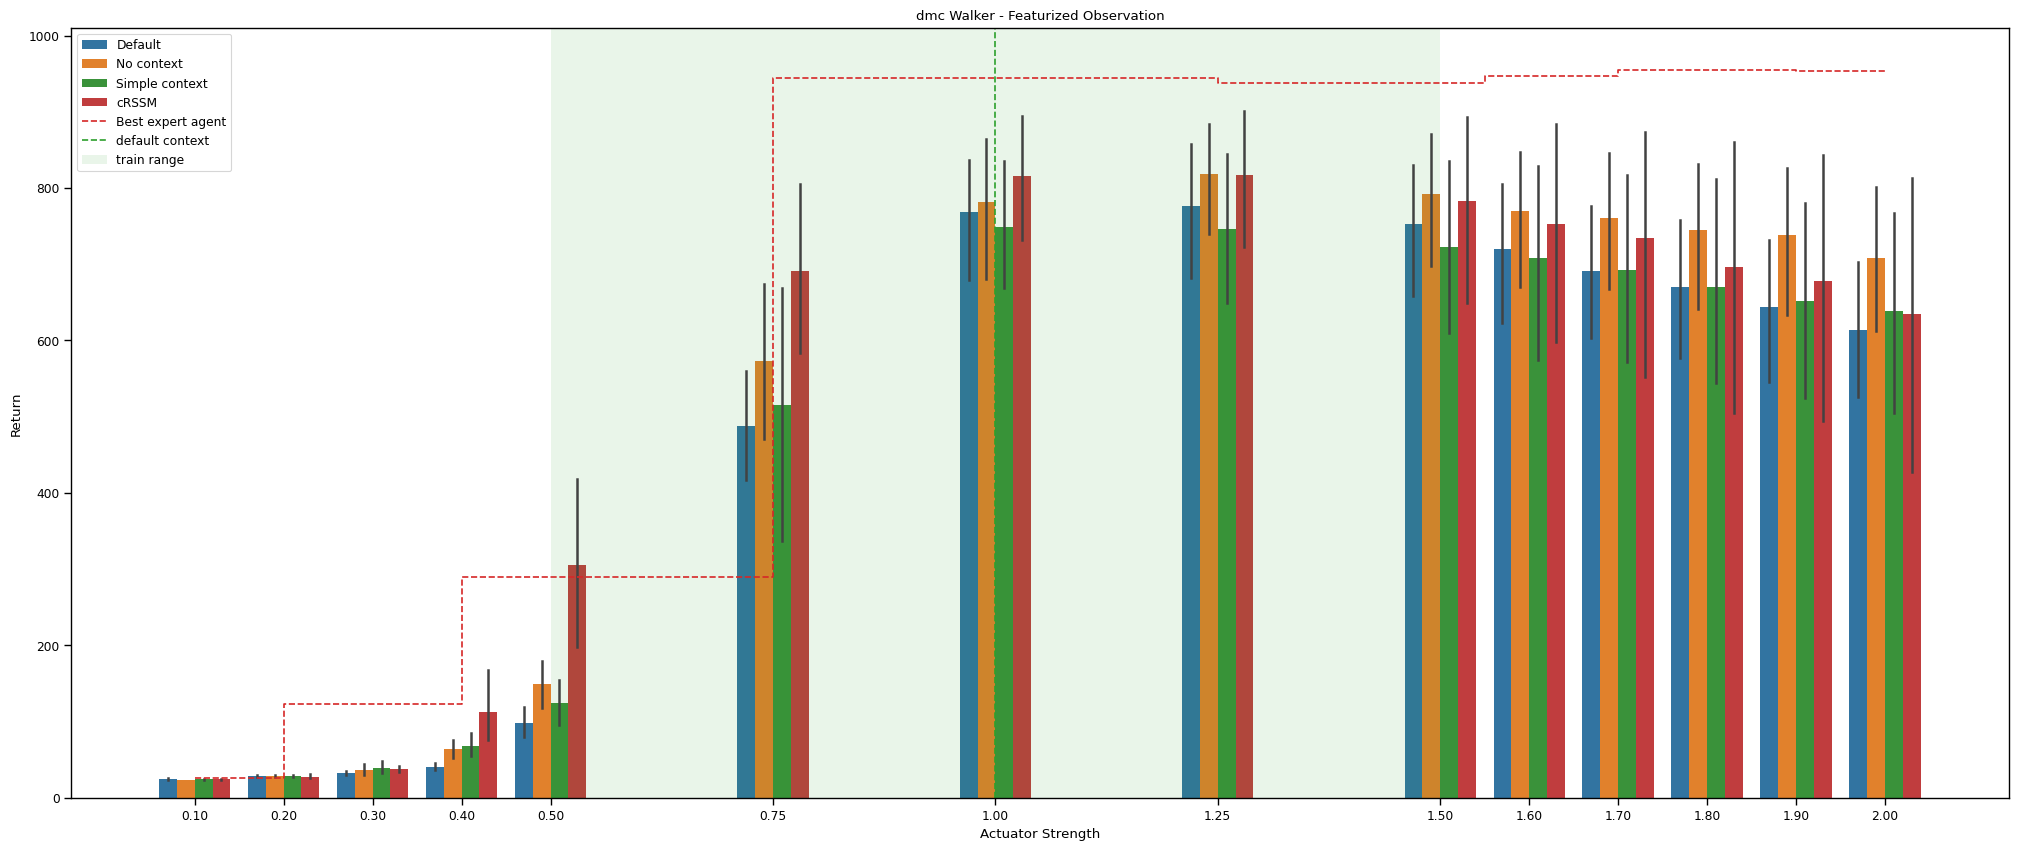

[PosixPath('../logs/carl_dmc_walker_default_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_obs_ctx_dec_obs_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_obs_dec_obs_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Featurized Observation - 34
Return


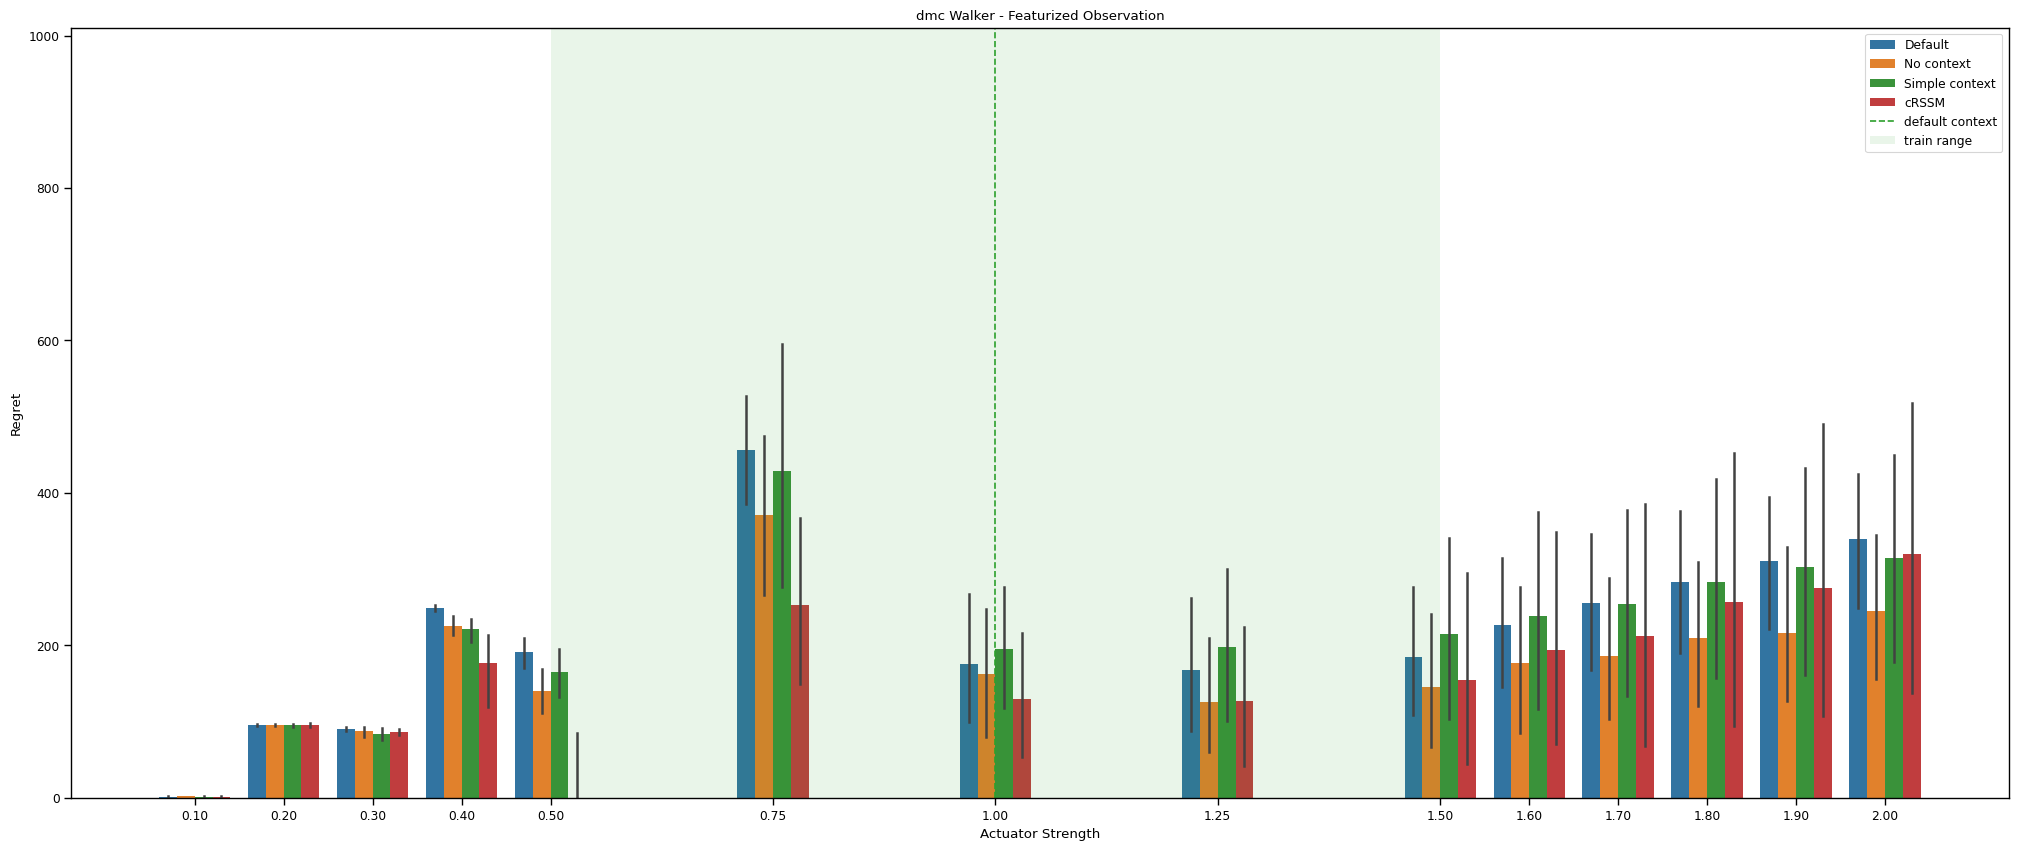

[PosixPath('../logs/carl_dmc_walker_default_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_obs_dec_obs_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_obs_ctx_dec_obs_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_obs_dec_obs_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Featurized Observation - 34
Regret


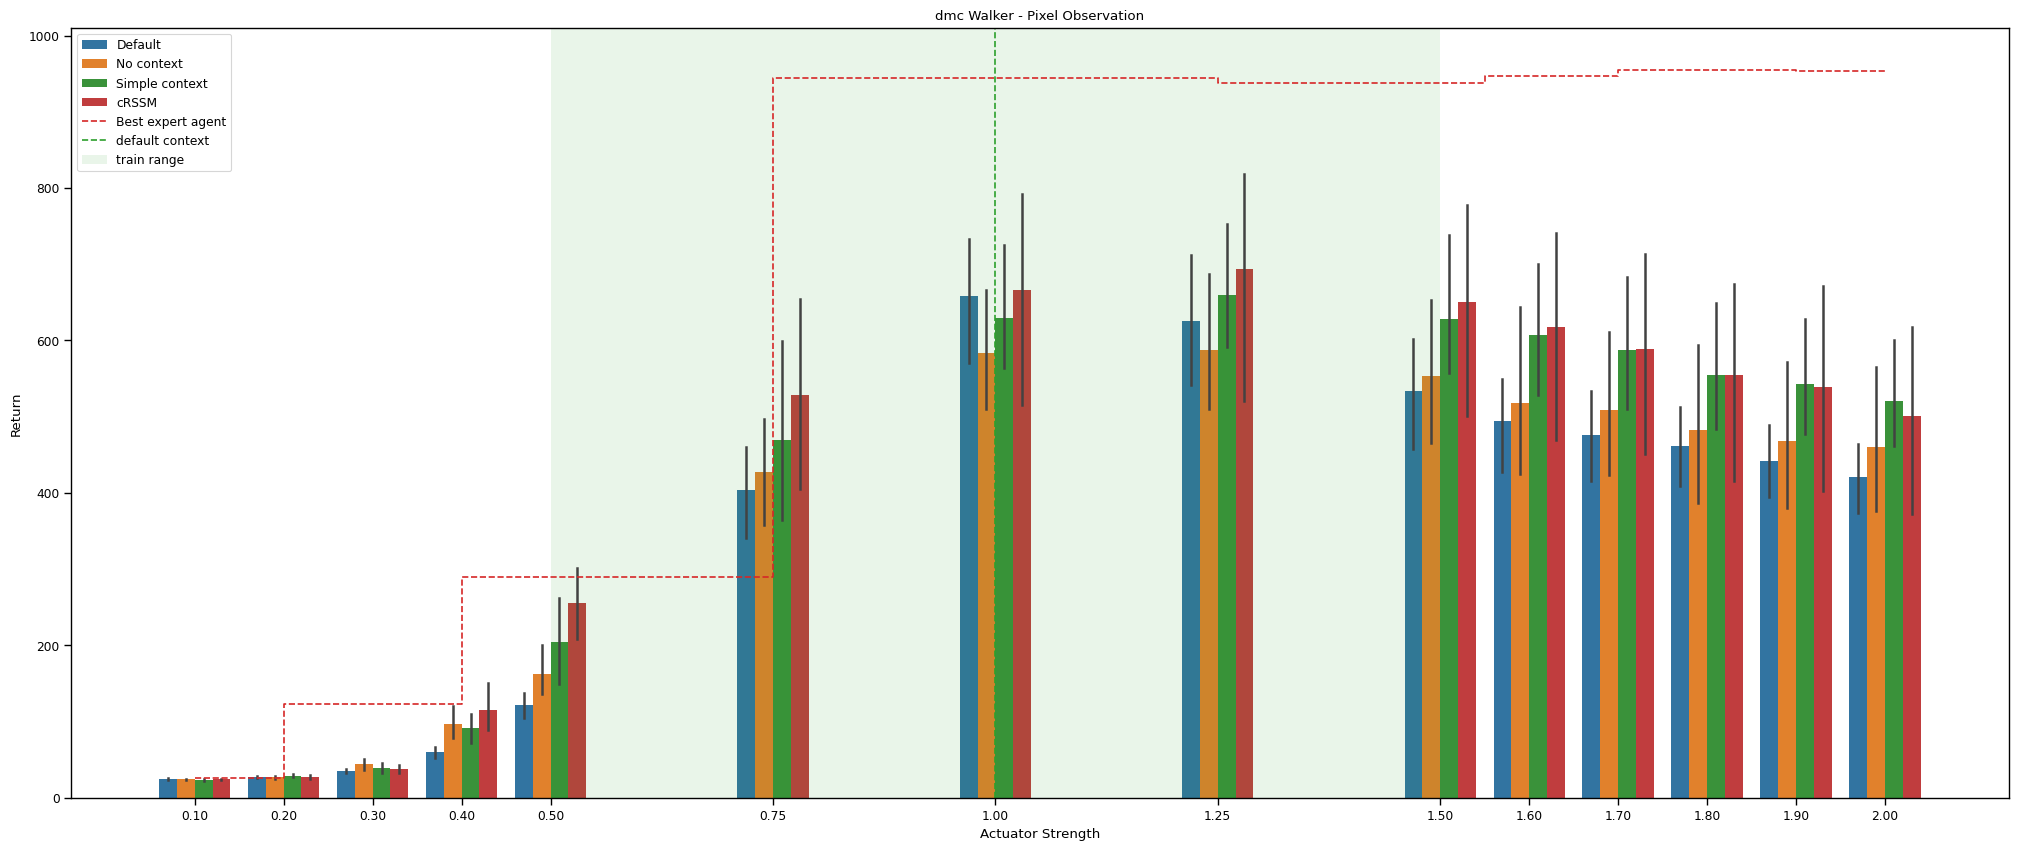

[PosixPath('../logs/carl_dmc_walker_default_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_img_ctx_dec_img_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_img_dec_img_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Pixel Observation - 31
Return


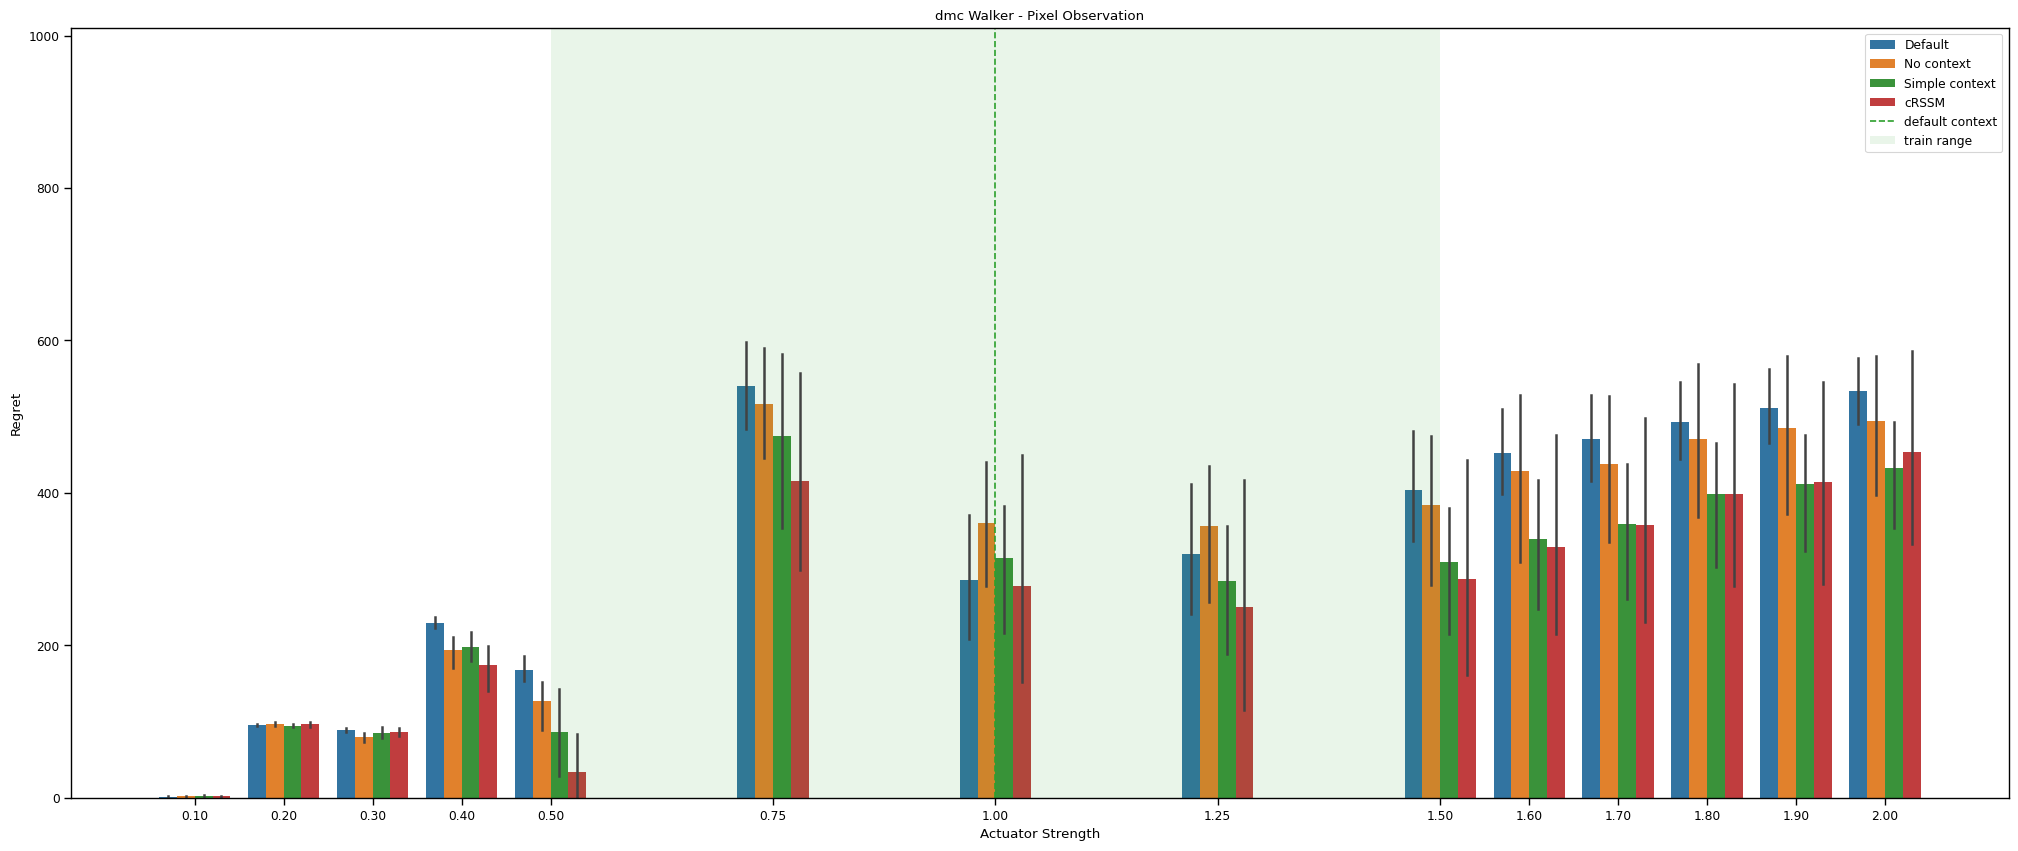

[PosixPath('../logs/carl_dmc_walker_default_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_img_dec_img_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_img_ctx_dec_img_ctx_normalized'), PosixPath('../logs/carl_dmc_walker_single_1_enc_img_dec_img_pgm_ctx_normalized')]
not enough seeds - dmc Walker - Pixel Observation - 31
Regret


In [85]:
tasks = ["classic_cartpole", "dmc_walker"]
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
    for context_id in context_ids:
        for modality in modalities:
            for plot_y in ["Return", "Regret"]:
                plot_bar_chart(task, context_id, modality, save_dir, logdir, best_agent_metrics, plot_y, "normalized")
                print(plot_y)

In [86]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np


def compute_regret(agent_metrics, best_agent_metrics):
    regret = {}
    min_ctx_0 = min([k[0] for k in agent_metrics])
    max_ctx_0 = max([k[0] for k in agent_metrics])
    min_ctx_1 = min([k[1] for k in agent_metrics])
    max_ctx_1 = max([k[1] for k in agent_metrics])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in best_agent_metrics
    ]
    best_keys = list(best_agent_metrics.keys())
    
    for current_key, mean_return in agent_metrics.items():
        normalized_current_key = ((current_key[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (current_key[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_current_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        nearest_best_return = best_agent_metrics[nearest_key]
        regret[current_key] = nearest_best_return - mean_return
    return regret

def compute_eval_regret(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, t_step="50k"):
    assert train_setting in ["default", "single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]

    
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
        ctx_type = "no context"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
        ctx_type = "simple context"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{t_step}"
        ctx_type = "cRSSM"
    else:
        raise RuntimeError("invalid ctx")

    modality = "featurized" if modality == "obs" else "pixel"
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or (train_setting == "default" and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.mean(v) for k, v in current_metrics.items()}
    
    best_metrics = best_agent_metrics[task]
    regret = compute_regret(agent_metrics, best_metrics)
    
    interpolate_ranges = [
        [default_0, default_0 + 1e-6],
        [default_1, default_1 + 1e-6]
    ]
    if context_idx is not None and train_setting == "single":
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    elif train_setting == "double_box":
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    interpolate_regret = []
    extrapolate_regret = []
    inter_extrapolate_regret = []
    for ctx_key in regret:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            interpolate_regret.append(regret[ctx_key])
        elif train_setting != "double_box" or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            extrapolate_regret.append(regret[ctx_key])
        else:
            inter_extrapolate_regret.append(regret[ctx_key])
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    
    return (task, train_setting, metric_context_name or f'{ctx_0},{ctx_1}', modality, ctx_type, np.mean(interpolate_regret), np.mean(extrapolate_regret), np.mean(inter_extrapolate_regret), np.mean(interpolate_regret + extrapolate_regret + inter_extrapolate_regret))

In [87]:

tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

df = pd.DataFrame(columns=["Task", "Train Setting", "Context", "Modality", "Inputs", "Interpolate Regret", "Extrapolate Regret", "Inter-Extra Regret", "Average Regret"])
import warnings
for task in tasks:
    for setting in ["single", "double_box"]:
        if setting == "single":
            context_ids = [0, 1]
        else:
            context_ids = [None]
        for ctx_id in context_ids:
            for modality in modalities:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    row = compute_eval_regret(logdir, task, "default", ctx_id, modality, "no_ctx", best_agent_metrics, "normalized")
                    df.loc[len(df)] = row
                    for ctx_type in ["no_ctx", "enc_dec_ctx", "pgm_ctx"]:
                        row = compute_eval_regret(logdir, task, setting, ctx_id, modality, ctx_type, best_agent_metrics, "normalized")
                        df.loc[len(df)] = row
# replace NaN with "N/A"

df = df.fillna("N/A")
df.to_csv(save_dir / "regret.csv", index=False)

In [88]:
import json

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle


def plot2d(logdir, save_dir, task, modality, train_mode, ctx, plot_key, exp_suffix):

    data = defaultdict(list)

    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]

    if train_mode == "default":
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        interpolate_range_0 = [default_0, default_0]
        interpolate_range_1 = [default_1, default_1]
    else:
        interpolate_range_0 = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_range_1 = _TASK2CONTEXTS[task][1]["train_range"]

    if ctx == "no_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_{exp_suffix}"
        ctx_text = "No context"
    elif ctx == "enc_dec_ctx":
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_ctx_dec_{modality}_ctx_{exp_suffix}"
        ctx_text = "Simple context"
    else:
        exp_path = logdir / f"carl_{task}_{train_mode}_enc_{modality}_dec_{modality}_pgm_ctx_{exp_suffix}"
        ctx_text = "cRSSM"
    modality = "Featurized obs" if modality == "obs" else "Pixel obs"
    seeds = 0
    experiment = exp_path.name
    for seed_path in exp_path.iterdir():
        seed = int(seed_path.name)

        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        seeds += 1
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        for line in lines:
            
            ctx_0_value = line['ctx']["context"][ctx_0]
            ctx_1_value = line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            data[(ctx_0_value, ctx_1_value)].append(ret)


    min_ctx_0 = min([k[0] for k in data])
    max_ctx_0 = max([k[0] for k in data])
    min_ctx_1 = min([k[1] for k in data])
    max_ctx_1 = max([k[1] for k in data])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in best_agent_metrics[task]
    ]
    
    x = []
    y = []
    c = []
    mean_regret = []
    for ctx_0_value, ctx_1_value in data:
        x.append(ctx_0_value)
        y.append(ctx_1_value)
        c.append(np.mean(data[(ctx_0_value, ctx_1_value)]))
        normalized_key = ((ctx_0_value - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (ctx_1_value - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = list(best_agent_metrics[task].keys())[nearest_index]
        nearest_best_return = best_agent_metrics[task][nearest_key]
        mean_regret.append(nearest_best_return - np.mean(data[(ctx_0_value, ctx_1_value)]))

    ctx_0 = ctx_0.replace("_", " ").title()
    ctx_1 = ctx_1.replace("_", " ").title()

    df = pd.DataFrame({ctx_0: x, ctx_1: y, "return": c, "regret": mean_regret})
    df = df.pivot(index=ctx_0, columns=ctx_1, values=plot_key)
    
    # sort the rows descending
    df = df.sort_index(ascending=False)

    
    # darker colors for higher values, red color map
    ax = sns.heatmap(df, cmap=sns.cm.rocket_r if plot_key == "return" else sns.cm.crest_r, annot=True, fmt=".0f")
    

    h_index_0 = df.index.searchsorted(interpolate_range_0[0], 'left', df.index.argsort())
    h_index_1 = df.index.searchsorted(interpolate_range_0[1], 'right', df.index.argsort())

    v_index_0 = df.columns.searchsorted(interpolate_range_1[0], 'left')
    v_index_1 = df.columns.searchsorted(interpolate_range_1[1], 'right')
    
    ax.add_patch(Rectangle((v_index_0, h_index_0), (v_index_1 - v_index_0), (h_index_1 - h_index_0), fill=False, edgecolor='g', linestyle='--', linewidth=2))
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    
    
    plt.title(f"{task} - {modality} - {ctx_text} - {plot_key.title()}")
    
    plt.savefig(save_dir / f"{task}_{train_mode}_{modality}_{ctx}_{plot_key}.pdf")
    
    if seeds != 10:
        print(f"not enough seeds - {task} - {modality} - {ctx} - {seeds}")
    
    # clear plt
    plt.pause(0.1)
    return df

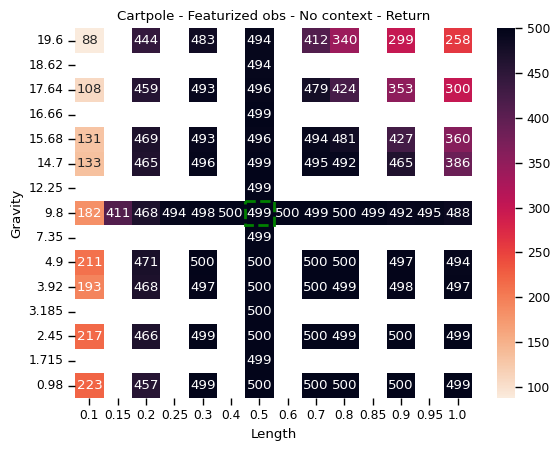

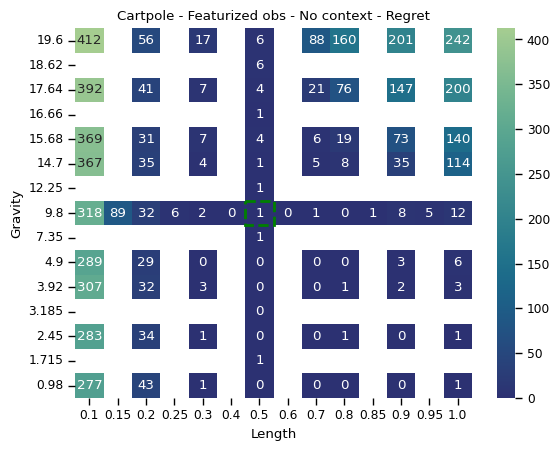

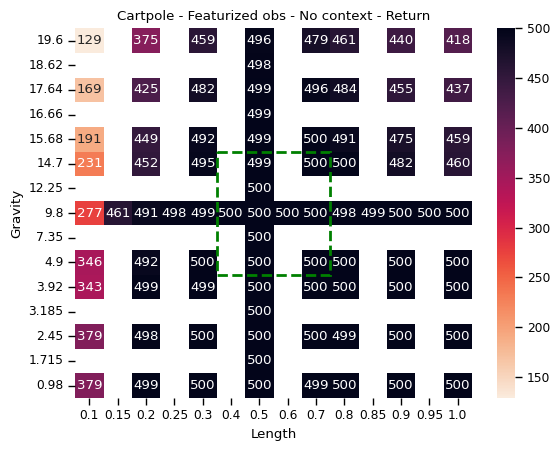

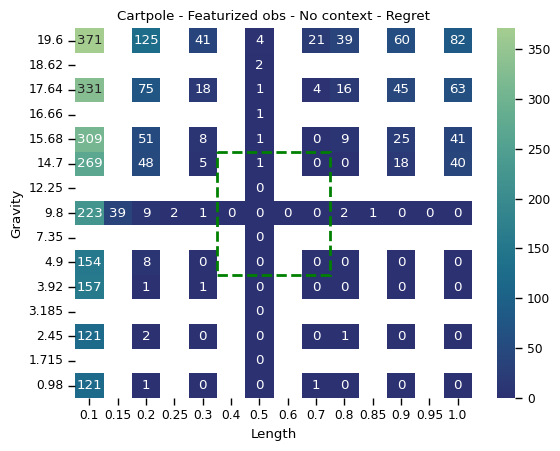

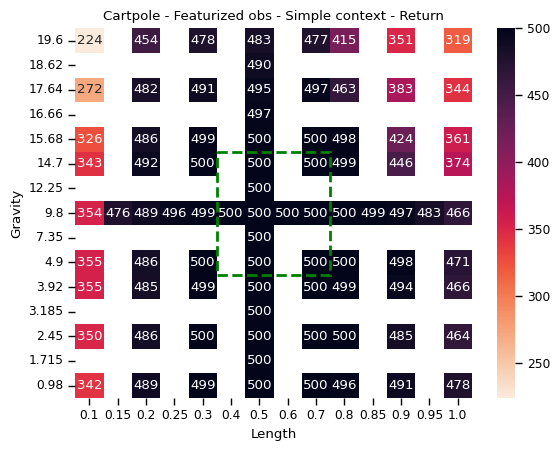

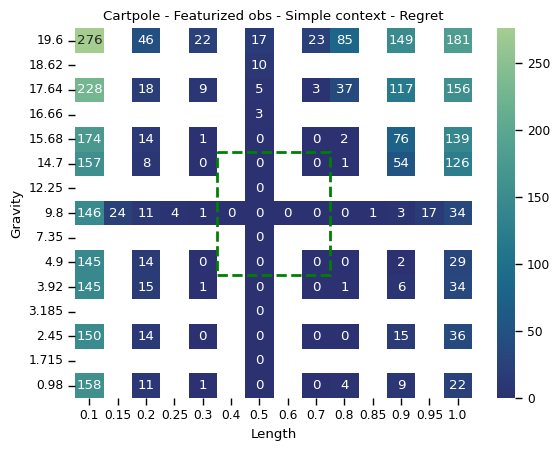

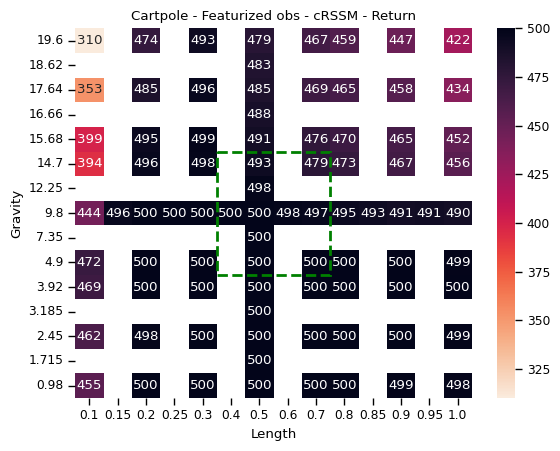

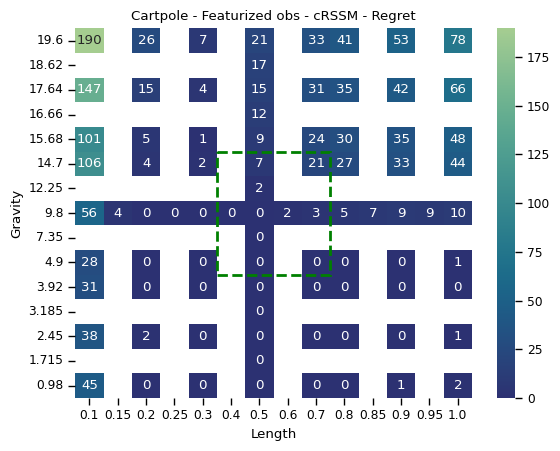

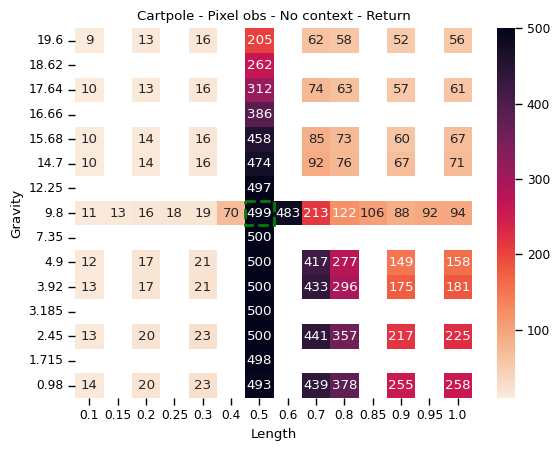

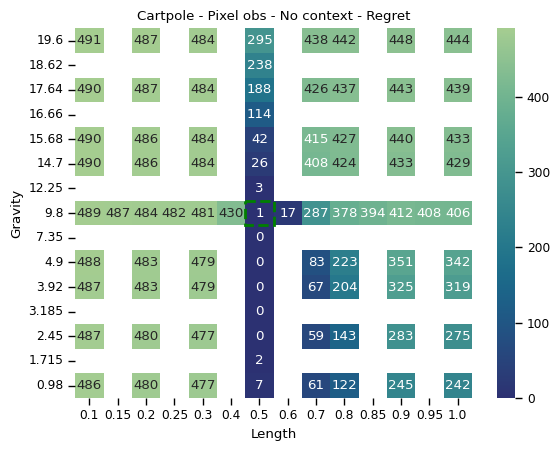

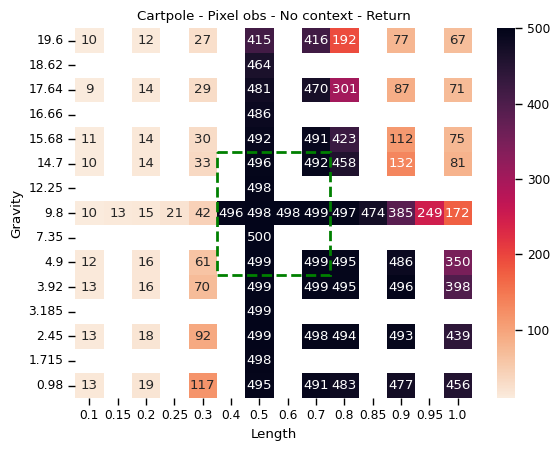

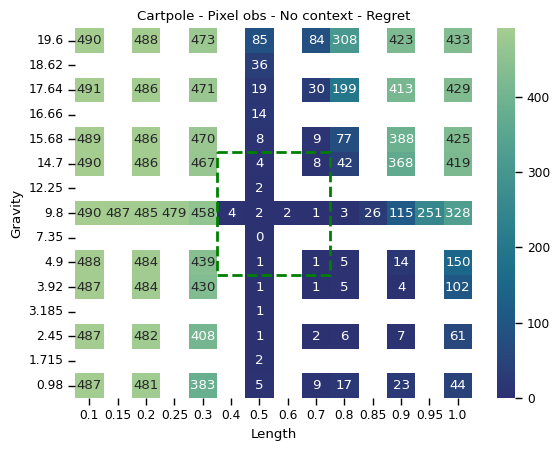

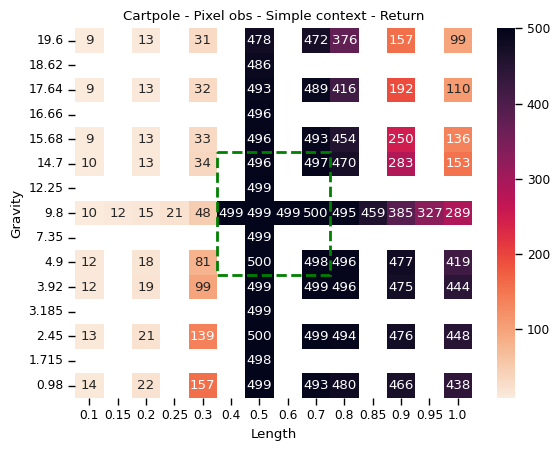

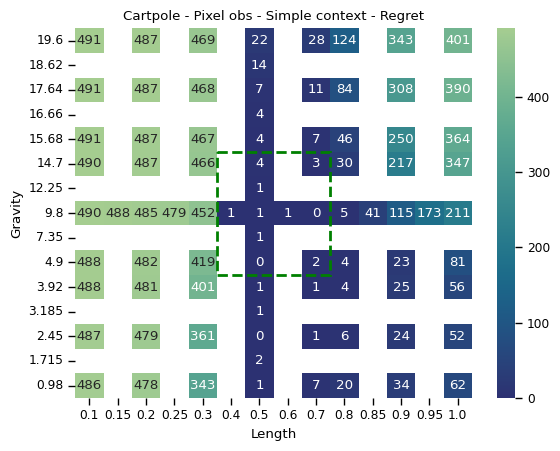

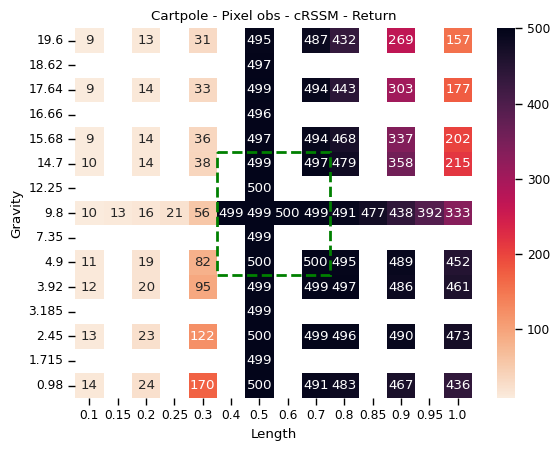

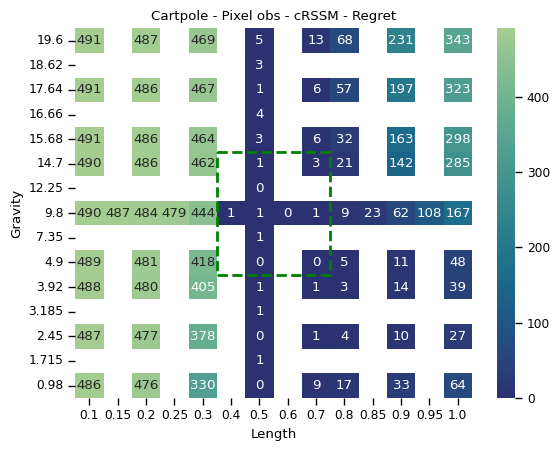

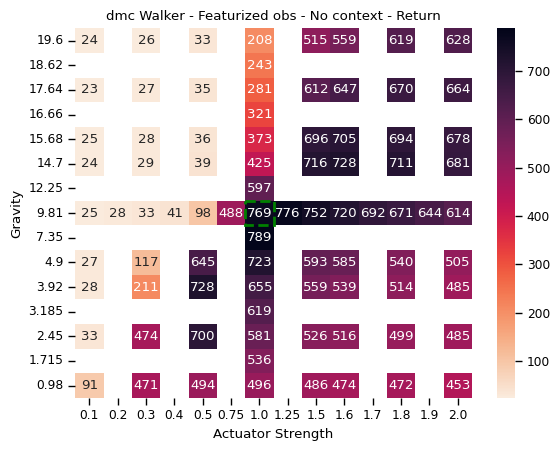

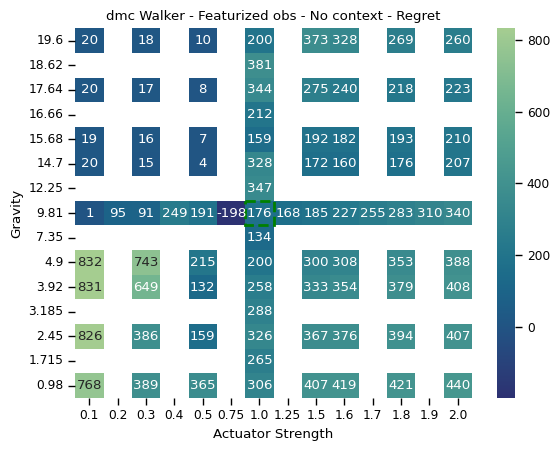

not enough seeds - dmc Walker - Featurized obs - no_ctx - 8


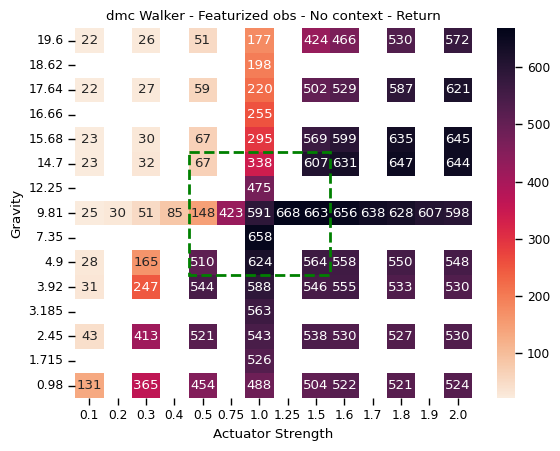

not enough seeds - dmc Walker - Featurized obs - no_ctx - 8


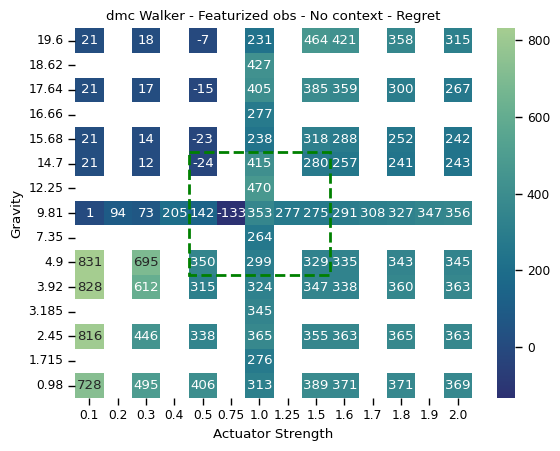

not enough seeds - dmc Walker - Featurized obs - enc_dec_ctx - 8


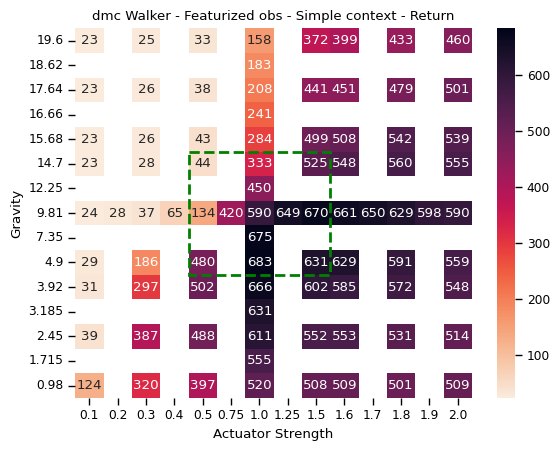

not enough seeds - dmc Walker - Featurized obs - enc_dec_ctx - 8


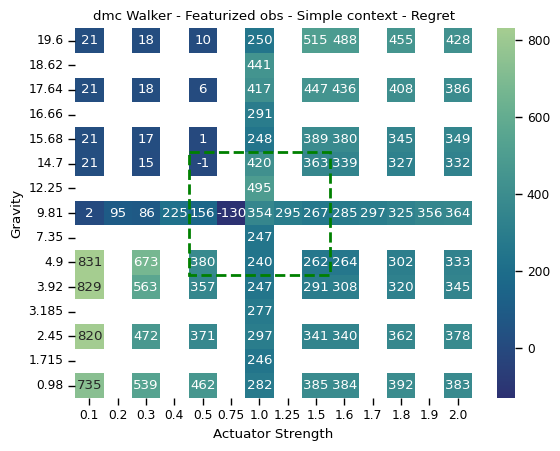

not enough seeds - dmc Walker - Featurized obs - pgm_ctx - 7


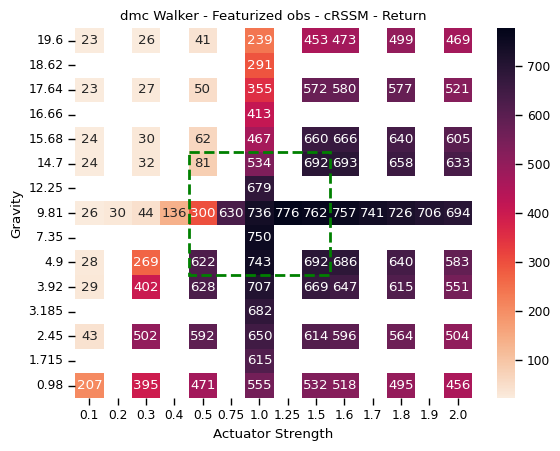

not enough seeds - dmc Walker - Featurized obs - pgm_ctx - 7


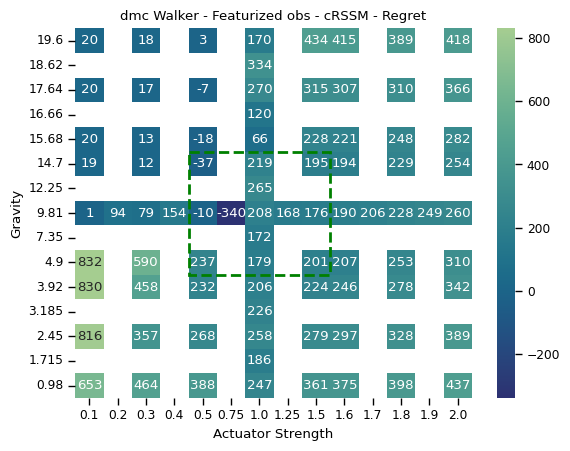

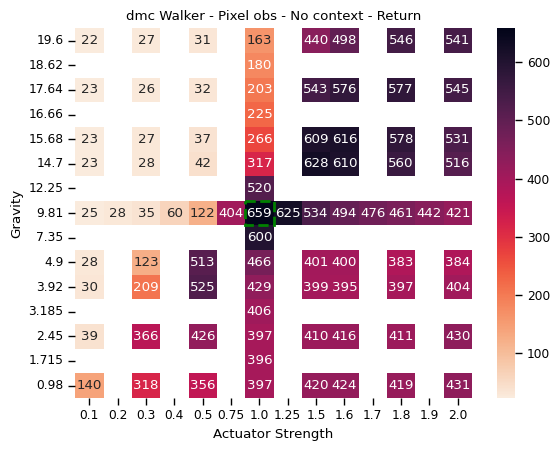

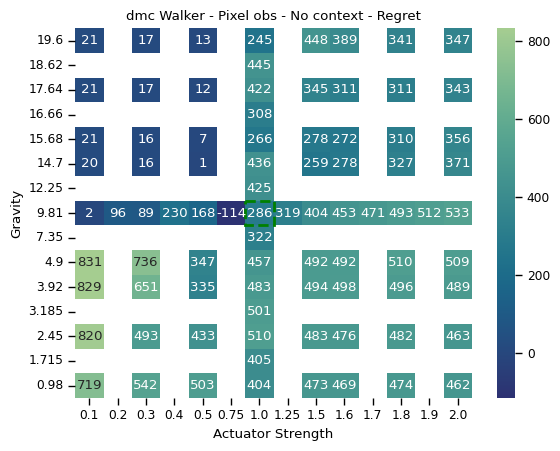

not enough seeds - dmc Walker - Pixel obs - no_ctx - 7


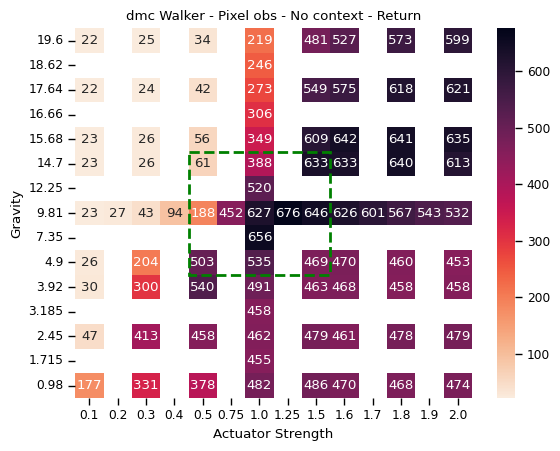

not enough seeds - dmc Walker - Pixel obs - no_ctx - 7


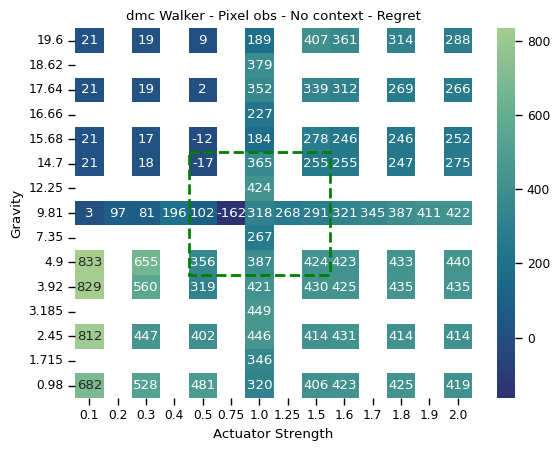

not enough seeds - dmc Walker - Pixel obs - enc_dec_ctx - 8


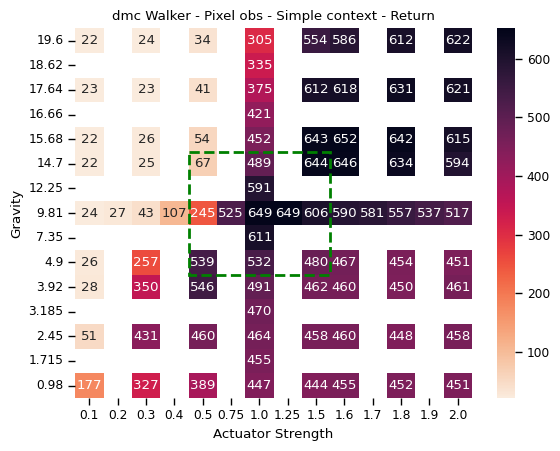

not enough seeds - dmc Walker - Pixel obs - enc_dec_ctx - 8


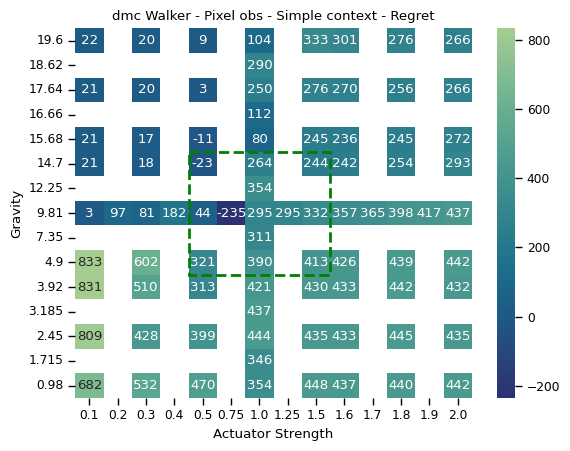

not enough seeds - dmc Walker - Pixel obs - pgm_ctx - 8


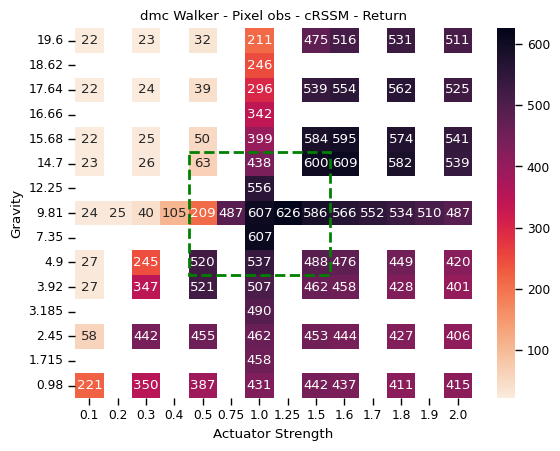

not enough seeds - dmc Walker - Pixel obs - pgm_ctx - 8


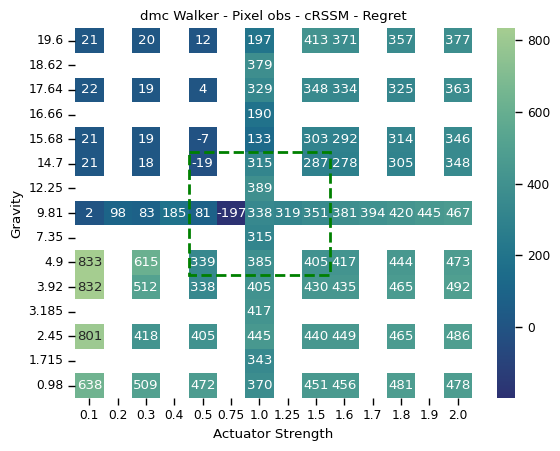

In [89]:
exp_suffix = "normalized"
tasks = ["classic_cartpole", "dmc_walker"]
modalities = ["obs", "img"]
train_modes = ["default", "double_box"]
logdir = Path("../logs") 

save_dir = Path("./plots/")
for task in tasks:
    for modality in modalities:
        for train_mode in train_modes:
            plot2d(logdir, save_dir, task, modality, train_mode, "no_ctx", "return", exp_suffix)
            plot2d(logdir, save_dir, task, modality, train_mode, "no_ctx", "regret", exp_suffix)
            if train_mode == "double_box":
                plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", "return", exp_suffix)
                plot2d(logdir, save_dir, task, modality, train_mode, "enc_dec_ctx", "regret", exp_suffix)         
                plot2d(logdir, save_dir, task, modality, train_mode, "pgm_ctx", "return", exp_suffix)
                plot2d(logdir, save_dir, task, modality, train_mode, "pgm_ctx", "regret", exp_suffix)         
